# AML Final Project: White Blood Cell Classification
## Bounding Box (Object Detection) Model
### Adam Finch, Pranay Reddy Gundala, and Tyler Rowe

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from object_detection.utils import visualization_utils as vis_util

import ultralytics
from ultralytics import YOLO
from IPython import display
from IPython.display import display, Image

In [2]:
import os 
HOME = os.getcwd()
print(HOME)

/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel


In [3]:
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.11.5 torch-2.1.0 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 138.0/228.3 GB disk)


For our bounding box object detection model, we wanted to take advantage of YOLOv8. 

YOLOv8 is the most recent version of the "You Only Look Once" (YOLO) object detection algorithm developed by Ultralytics. 

YOLOv8 made sense for our project for a couple of reasons: 

   1. _It is straightforward to take a custom labeled dataset and train a model based on the YOLO algorithm._
   
   2. _Once trained, the model can provide almost instantaneous predictions for new images. Real time processing capabilities is a huge benefit in the field of medical imaging._

   3. _YOLOv8 can handle multiple classes simultaneously, which hopefully will allow the model to pick out white blood cells even when surrounded by red blood cells and platelets._





The first step towards training a model with YOLOv8 was to upload our images, as well as the labels csv file ('bounding_box_annotations.csv') created in the previous step of our project to Roboflow. Here is a link to our project on Roboflow: 

https://universe.roboflow.com/iu-msds-projects/aml-wbc-classification

In [4]:
# We can then easily load the dataset into Jupyter Notebook: 

from roboflow import Roboflow
rf = Roboflow(api_key="lZQOLsTcmOVCVhTb4pLE")
project = rf.workspace("iu-msds-projects").project("aml-wbc-classification")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AML-WBC-Classification-2 in yolov8:: 100%|█| 1


Next we trained the object detection model. Roboflow allowed us to automatically apply preprocessing techniques to the images.

After some experimentation, we found that "Auto-Adjust Contrast: Using Adaptive Equalization" in Roboflow was an important preprocessing step due to the White Blood Cells being most differentiable by color. Additionally, we utilized the Augmentation Steps "Flip: Horizontal, Vertical" and "Rotation: Between -15° and +15°" to ensure that the model could detect blood cells no matter the orientation of the image. 

Once preprocessing was complete, we trained the model using the yolov8 algorithm with 25 epochs. 

In [5]:

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel
100%|██████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 25.9MB/s]
New https://pypi.org/project/ultralytics/8.0.208 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.11.5 torch-2.1.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AML-WBC-Classification-2/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True

The model took almost 10 hours to train. Next, we can explore the results of the model.

In [60]:
# Here is a list of all the files generated automatically through the training process: 

!ls {HOME}/runs/detect/train/

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
args.yaml
confusion_matrix.png
confusion_matrix_normalized.png
events.out.tfevents.1699633918.Adams-MacBook-Air-5.local.34390.0
labels.jpg
labels_correlogram.jpg
model_artifacts.json
results.csv
results.png
roboflow_deploy.zip
state_dict.pt
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
train_batch720.jpg
train_batch721.jpg
train_batch722.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights


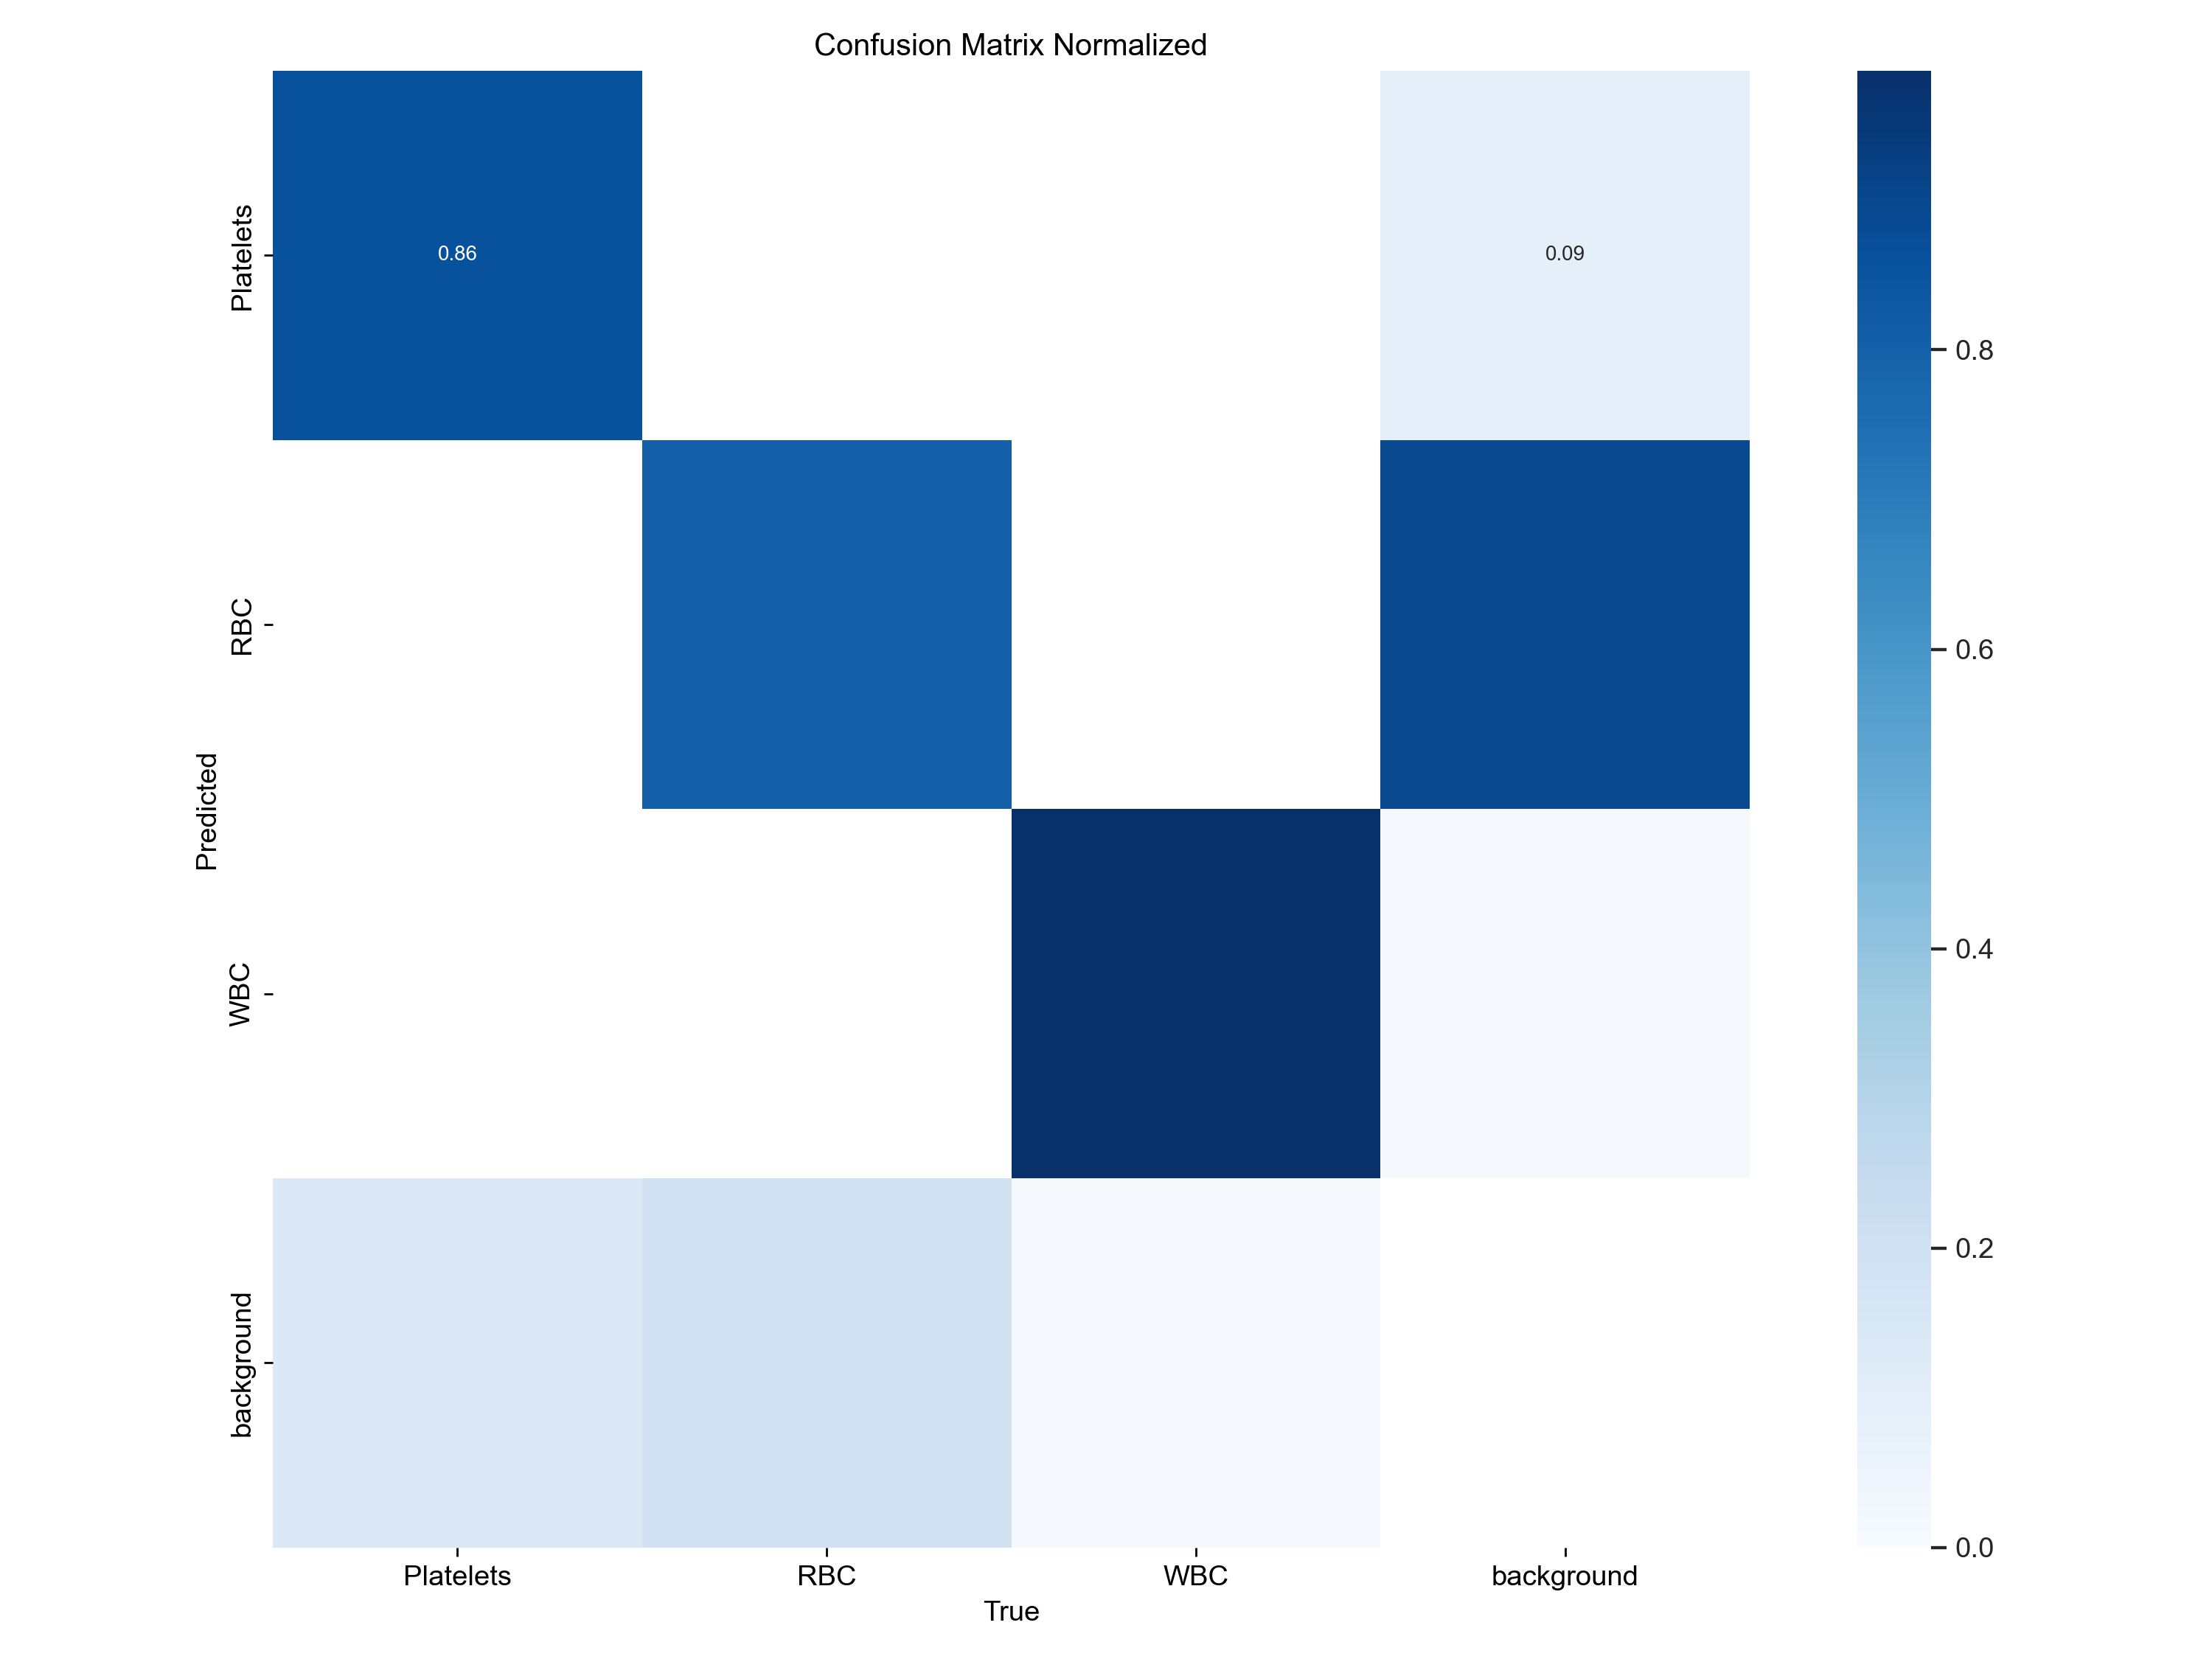

In [83]:
# Code to print the confusion matrix image:

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=1000)

The confusion matrix shows that the model does a very good job differentiating between RBC, WBC, and Platelets. It very rarely bounds an object and classifies it incorrectly. However, there were cases where it failed to detect a blood cell in the image. The most common errors were classifying something as background when it was really one of the three cell types. Another encouraging sign is that White Blood Cells were the easiest for the model to classify correctly. 

Here are a few visualizations of the model's performance:

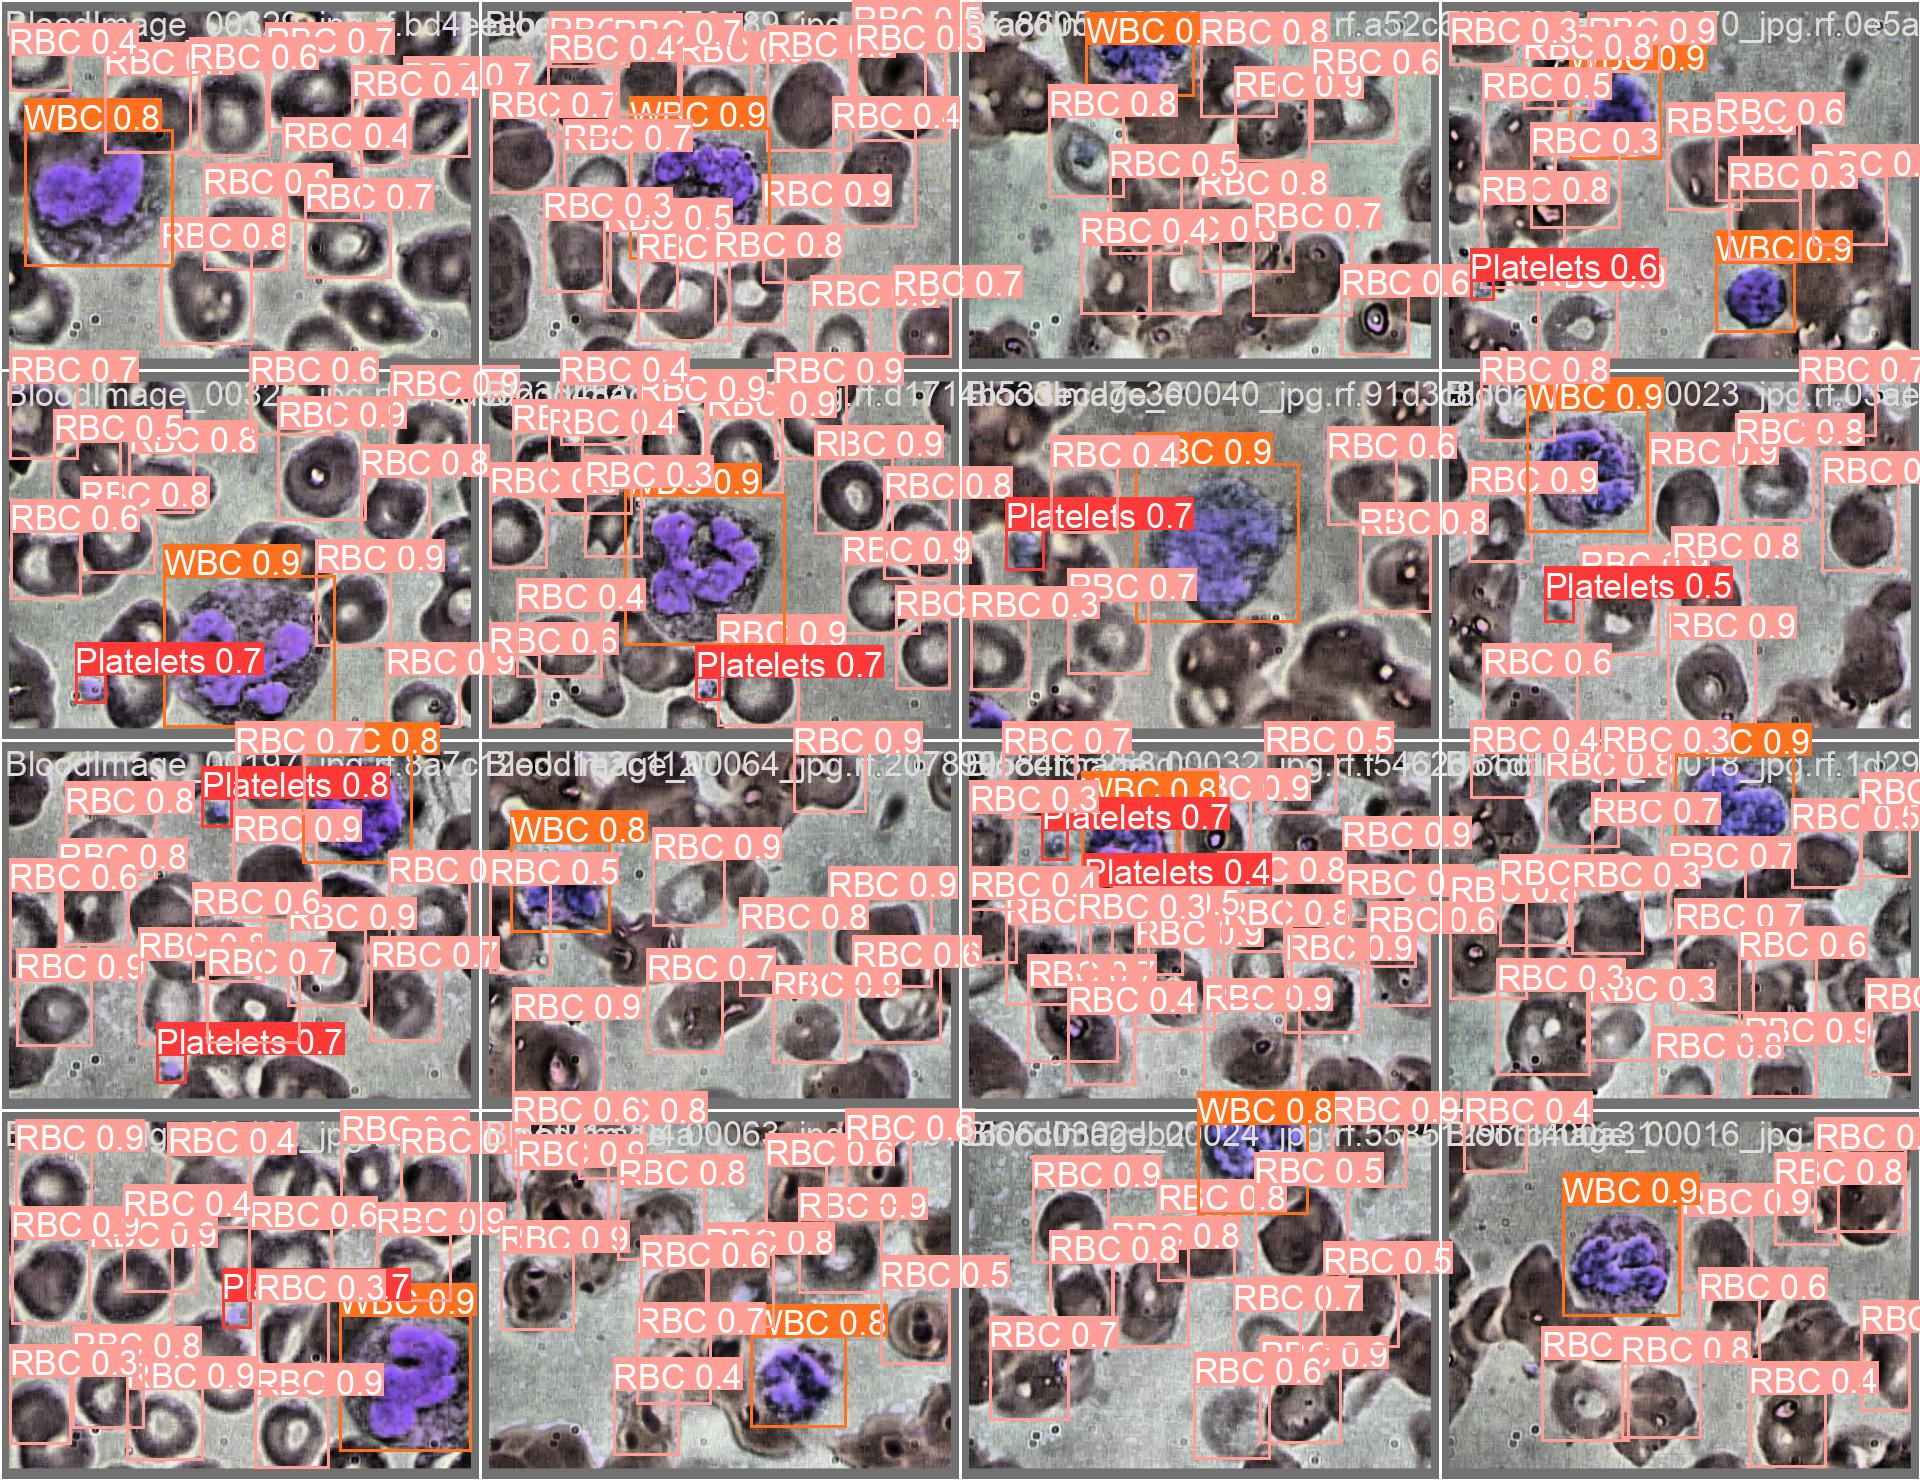

In [85]:
Image(filename=f'{HOME}/runs/detect/train/val_batch1_pred.jpg', width=1500)

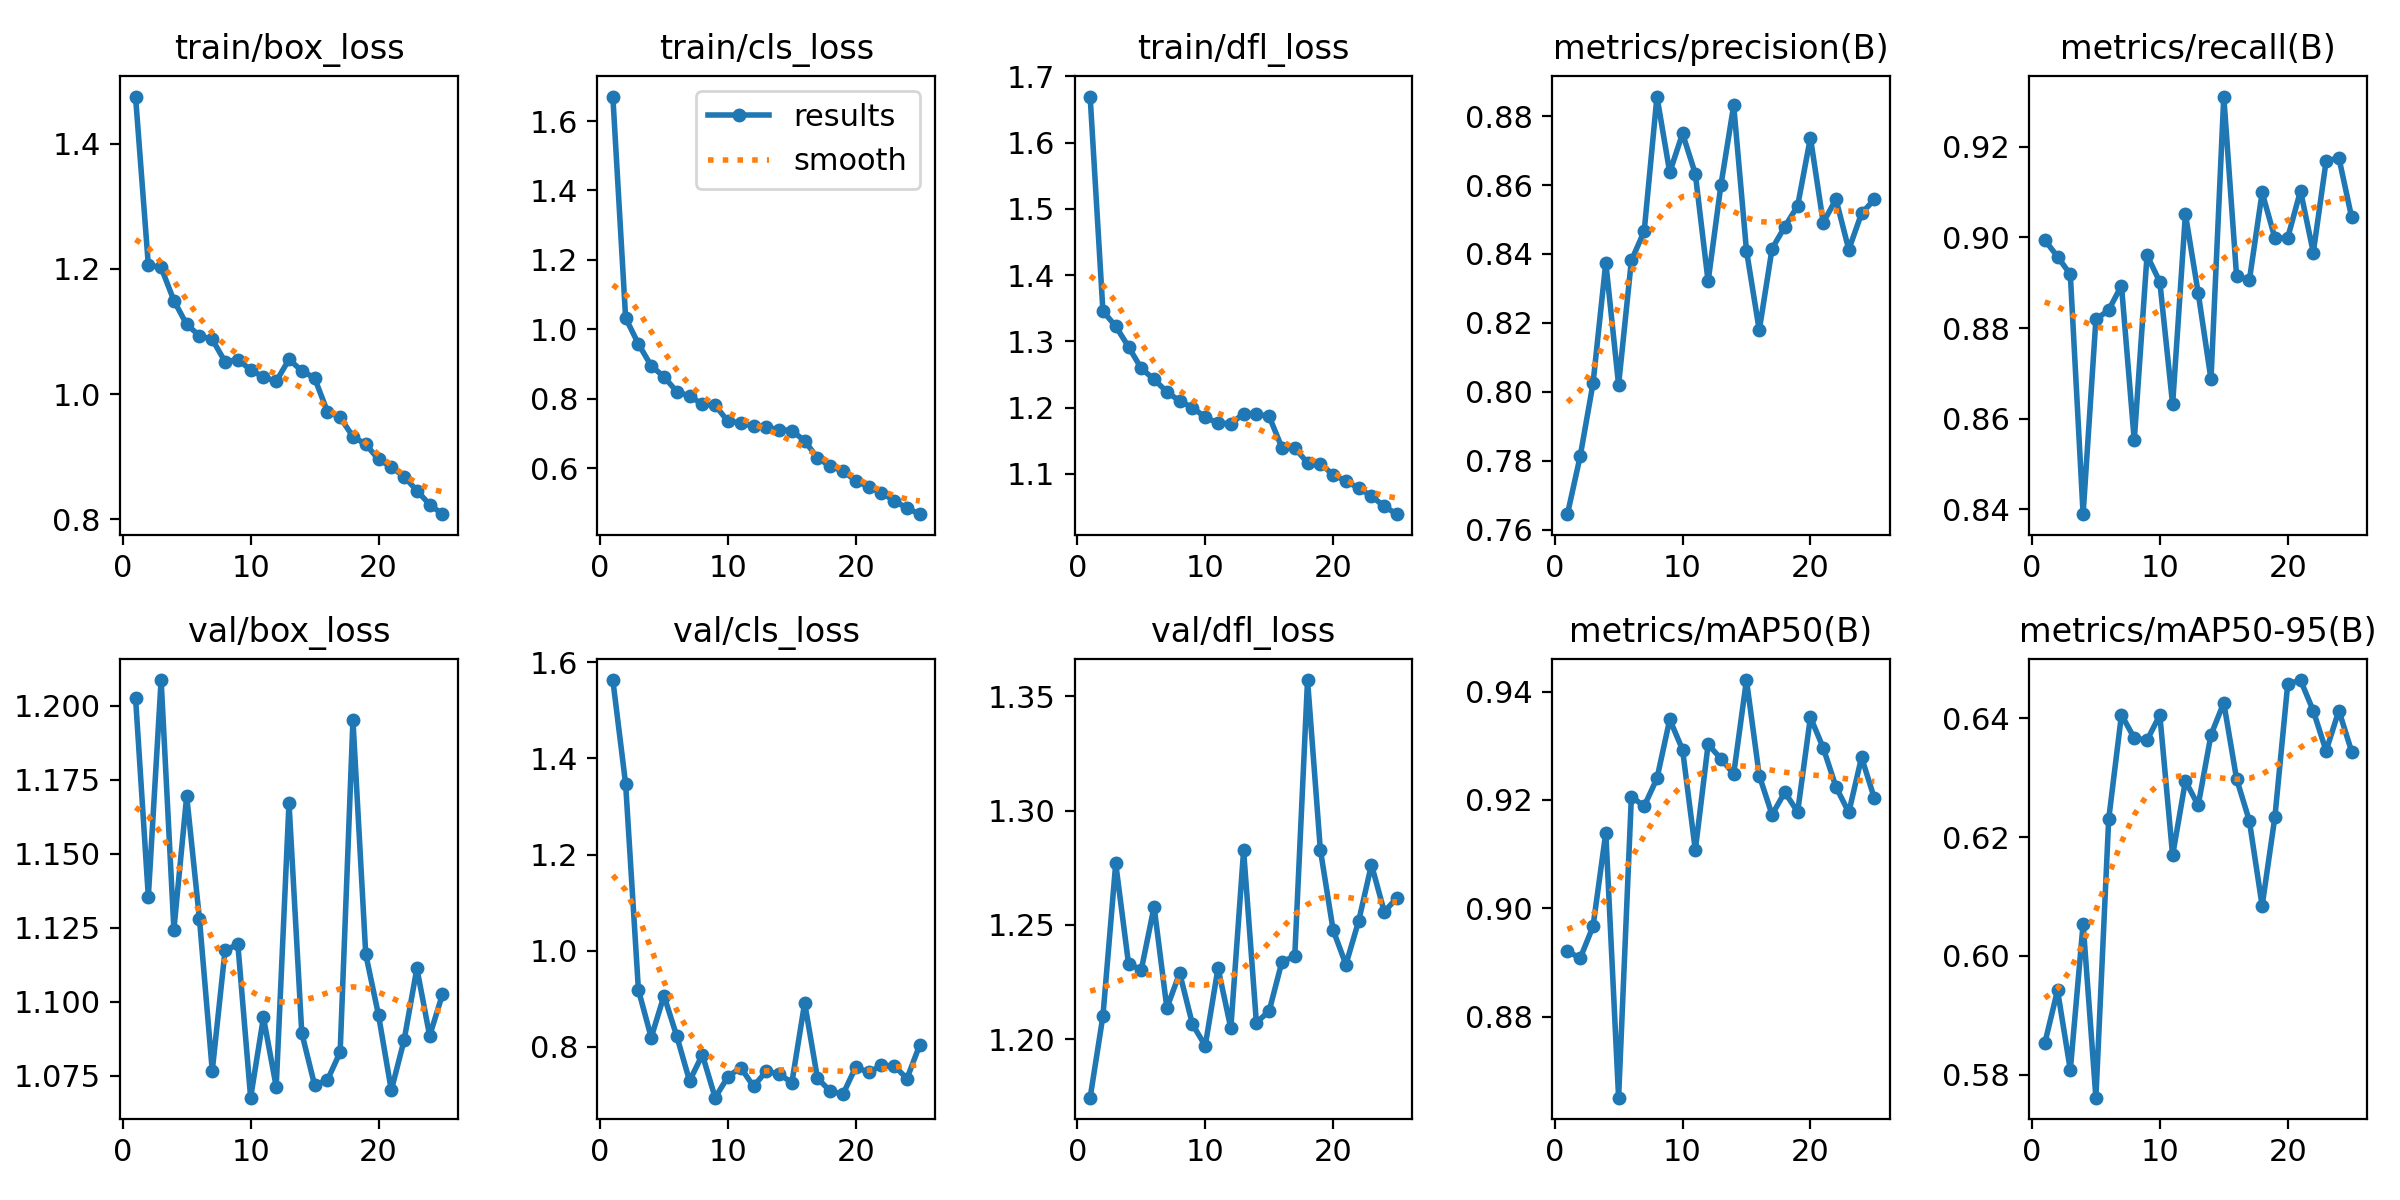

In [86]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=1500)

Model validation and predictions on test set: 

In [33]:


!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel
Ultralytics YOLOv8.0.196 🚀 Python-3.11.5 torch-2.1.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AM
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         73       1036       0.85       0.91       0.93      0.646
             Platelets         73         72      0.798      0.903      0.909      0.477
                   RBC         73        890      0.788      0.842      0.897      0.647
                   WBC         73         74      0.963      0.986      0.983      0.815
Speed: 1.6ms preprocess, 365.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /opt/homebrew/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [35]:
# Prediction on the test set images:

!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel
Ultralytics YOLOv8.0.196 🚀 Python-3.11.5 torch-2.1.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

image 1/37 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AML-WBC-Classification-2/test/images/BloodImage_00015_jpg.rf.692b92361046166184d35c3eddf16e0c.jpg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 173.5ms
image 2/37 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AML-WBC-Classification-2/test/images/BloodImage_00017_jpg.rf.9ed4c1e9a635b18c27dfb6d1622325f1.jpg: 608x800 1 Platelets, 17 RBCs, 1 WBC, 149.5ms
image 3/37 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AML-WBC-Classification-2/test/images/BloodImage_00019_jpg.rf.c5bf63a7cc3965e75fe7ea963c14d7b3.jpg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 146.2ms
image 4/37 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/AML-WBC-Classification-2/test/images/BloodImage_00034_

Visualize test set results:

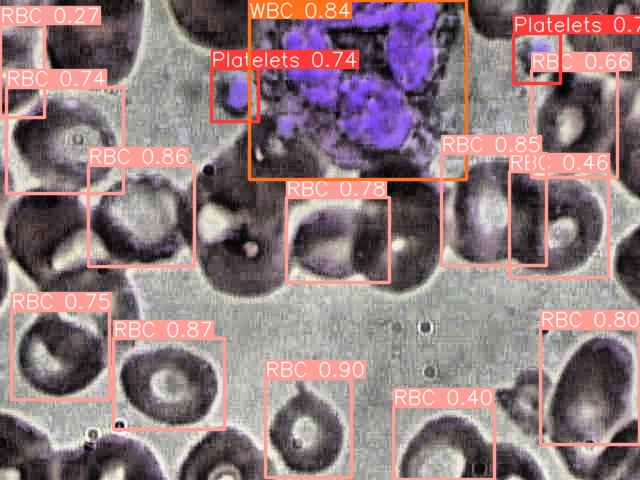

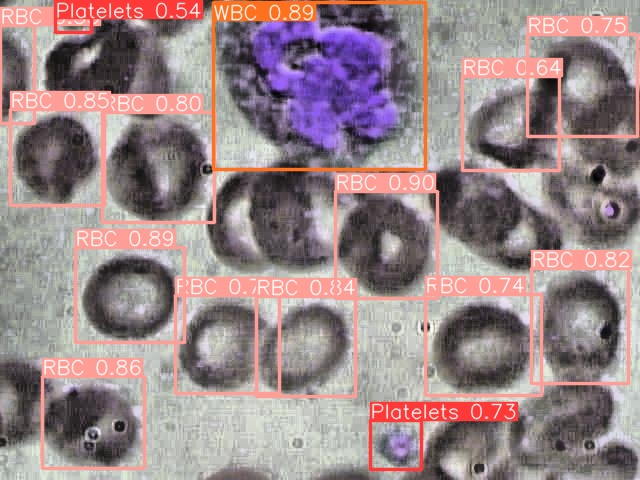

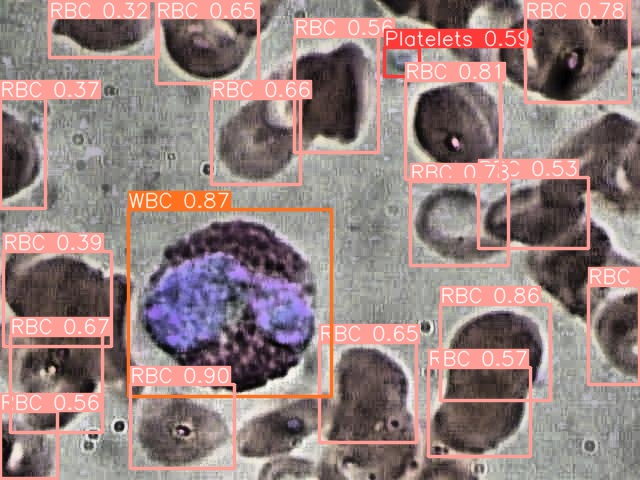

In [87]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [40]:
#Deploy model to Roboflow using the best weights found during training: 

project.version(3).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/iu-msds-projects/aml-wbc-classification/3
Share your model with the world at: https://universe.roboflow.com/iu-msds-projects/aml-wbc-classification/model/3


Finally, we want to use the weights to predict bounding boxes for each image in dataset2-master: 

In [88]:
# Use the weights found above during training:
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

#Lists to loop through all the images in dataset2-master:
folders = ['TEST', 'TEST_SIMPLE', 'TRAIN']
wbc_subtypes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [79]:
#New directory to store results in:
%cd /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-predictions

for i in folders:
    for j in wbc_subtypes:
        model.predict(source = f'{HOME}/dataset2-master/images/{i}/{j}',
                      conf = 0.25,
                      save = True,
                      save_txt = True,
                      save_crop = True,
                      project = i,
                      name = j
                      )

/Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-predictions


image 1/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 184.5ms
image 2/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_1794.jpeg: 608x800 2 Plateletss, 5 RBCs, 146.4ms
image 3/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_1845.jpeg: 608x800 9 RBCs, 1 WBC, 145.5ms
image 4/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_187.jpeg: 608x800 2 Plateletss, 5 RBCs, 149.9ms
image 5/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_196.jpeg: 608x800 8 RBCs, 1 WBC, 146.9ms
image 6/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_0_2107.jpeg: 608x800 1 Platelets, 5 RBCs, 152.4ms
image 7/

image 50/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_1104.jpeg: 608x800 12 RBCs, 1 WBC, 142.6ms
image 51/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_1367.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 143.4ms
image 52/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_1626.jpeg: 608x800 4 Plateletss, 6 RBCs, 147.0ms
image 53/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_1830.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 145.0ms
image 54/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_2029.jpeg: 608x800 4 RBCs, 142.0ms
image 55/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_10_2539.jpeg: 608x800 2 Plateletss, 8 RBCs, 1

image 100/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_1706.jpeg: 608x800 15 RBCs, 144.2ms
image 101/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_2036.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 142.1ms
image 102/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_204.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 146.0ms
image 103/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_2463.jpeg: 608x800 9 RBCs, 1 WBC, 143.1ms
image 104/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_2469.jpeg: 608x800 10 RBCs, 1 WBC, 263.2ms
image 105/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_11_3152.jpeg: 608x800 1 Platelets, 1 RBC, 144.

image 150/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_1610.jpeg: 608x800 10 RBCs, 157.0ms
image 151/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_1668.jpeg: 608x800 12 RBCs, 146.9ms
image 152/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_205.jpeg: 608x800 10 RBCs, 1 WBC, 144.3ms
image 153/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_2342.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 145.7ms
image 154/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_2378.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 148.7ms
image 155/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_12_2782.jpeg: 608x800 16 RBCs, 148.2ms
image 156/623 

image 200/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_2584.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 144.3ms
image 201/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_2728.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 143.2ms
image 202/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_3150.jpeg: 608x800 1 Platelets, 8 RBCs, 147.2ms
image 203/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_3444.jpeg: 608x800 9 RBCs, 2 WBCs, 147.6ms
image 204/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_3504.jpeg: 608x800 6 RBCs, 144.0ms
image 205/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_1_3670.jpeg: 608x800 8 RBCs, 1 WBC, 149.8ms
i

image 249/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_2446.jpeg: 608x800 1 Platelets, 8 RBCs, 149.1ms
image 250/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_276.jpeg: 608x800 11 RBCs, 1 WBC, 149.3ms
image 251/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_2784.jpeg: 608x800 3 Plateletss, 6 RBCs, 147.4ms
image 252/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_3032.jpeg: 608x800 1 Platelets, 16 RBCs, 150.2ms
image 253/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_3302.jpeg: 608x800 3 Plateletss, 5 RBCs, 1 WBC, 145.7ms
image 254/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_2_3408.jpeg: 608x800 1 Platelets, 7 RB

image 298/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_2945.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 142.9ms
image 299/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_3064.jpeg: 608x800 11 RBCs, 1 WBC, 153.6ms
image 300/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_3505.jpeg: 608x800 9 RBCs, 1 WBC, 149.5ms
image 301/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_3858.jpeg: 608x800 6 RBCs, 1 WBC, 146.2ms
image 302/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_407.jpeg: 608x800 1 Platelets, 16 RBCs, 1 WBC, 145.3ms
image 303/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_3_4263.jpeg: 608x800 1 Platelets, 10 RBCs, 1

image 347/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_3150.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 144.4ms
image 348/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_3226.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 148.0ms
image 349/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_3507.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 149.5ms
image 350/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_3550.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 138.1ms
image 351/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_408.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 151.0ms
image 352/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_4_4287

image 396/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_3208.jpeg: 608x800 9 RBCs, 1 WBC, 146.6ms
image 397/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_3338.jpeg: 608x800 9 RBCs, 1 WBC, 142.7ms
image 398/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_3931.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 144.9ms
image 399/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_408.jpeg: 608x800 2 Plateletss, 8 RBCs, 147.0ms
image 400/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_4335.jpeg: 608x800 4 RBCs, 1 WBC, 142.8ms
image 401/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_5_452.jpeg: 608x800 15 RBCs, 1 WBC, 144.0ms
image 4

image 445/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_3939.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 139.9ms
image 446/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_4062.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 143.5ms
image 447/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_4318.jpeg: 608x800 16 RBCs, 149.7ms
image 448/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_4338.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 142.2ms
image 449/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_4766.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 147.1ms
image 450/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_6_4942.jpeg: 608x800 2 P

image 494/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4236.jpeg: 608x800 9 RBCs, 1 WBC, 145.7ms
image 495/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4277.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 147.3ms
image 496/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4319.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 147.8ms
image 497/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4714.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 141.2ms
image 498/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4728.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 147.6ms
image 499/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_7_4817.jpeg: 608x8

image 543/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_4673.jpeg: 608x800 2 RBCs, 1 WBC, 146.6ms
image 544/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_4721.jpeg: 608x800 5 RBCs, 145.0ms
image 545/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_4745.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 138.1ms
image 546/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_5028.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 143.2ms
image 547/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_5290.jpeg: 608x800 7 RBCs, 1 WBC, 144.0ms
image 548/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_8_5743.jpeg: 608x800 4 RBCs, 1 WBC, 136.3ms
image 54

image 593/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_4384.jpeg: 608x800 8 RBCs, 1 WBC, 164.0ms
image 594/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_4638.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 147.8ms
image 595/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_4776.jpeg: 608x800 5 RBCs, 1 WBC, 139.3ms
image 596/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_4815.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 144.6ms
image 597/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_4854.jpeg: 608x800 5 RBCs, 1 WBC, 142.3ms
image 598/623 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/EOSINOPHIL/_9_5411.jpeg: 608x800 7 RBCs, 1 WBC, 146.3ms


image 19/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_3337.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 141.6ms
image 20/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_3396.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 150.5ms
image 21/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_3409.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 148.8ms
image 22/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_353.jpeg: 608x800 2 Plateletss, 13 RBCs, 153.9ms
image 23/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_3531.jpeg: 608x800 7 RBCs, 1 WBC, 141.0ms
image 24/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_3551.jpeg: 608x800 2 Platelets

image 68/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_6589.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 146.5ms
image 69/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_687.jpeg: 608x800 12 RBCs, 1 WBC, 142.6ms
image 70/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_6954.jpeg: 608x800 9 RBCs, 1 WBC, 148.0ms
image 71/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_6955.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 140.5ms
image 72/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_7040.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 142.5ms
image 73/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_0_7049.jpeg: 608x800 1 Platelets, 6 RBC

image 117/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2109.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 142.8ms
image 118/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2250.jpeg: 608x800 11 RBCs, 1 WBC, 143.9ms
image 119/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2388.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 143.6ms
image 120/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2434.jpeg: 608x800 6 RBCs, 1 WBC, 141.3ms
image 121/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2584.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 149.7ms
image 122/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_2592.jpeg: 608x800 1 Platele

image 166/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_5875.jpeg: 608x800 3 Plateletss, 5 RBCs, 1 WBC, 150.2ms
image 167/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_601.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 145.1ms
image 168/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_6075.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 145.0ms
image 169/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_6162.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 145.6ms
image 170/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_6573.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 145.8ms
image 171/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_1_658

image 215/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_2327.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 143.6ms
image 216/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_2398.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 144.0ms
image 217/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_2401.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 148.3ms
image 218/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_2506.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 146.8ms
image 219/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_2604.jpeg: 608x800 4 Plateletss, 5 RBCs, 1 WBC, 140.3ms
image 220/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_27

image 264/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_693.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 143.3ms
image 265/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_6958.jpeg: 608x800 9 RBCs, 1 WBC, 145.0ms
image 266/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_6996.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 144.5ms
image 267/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_704.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 147.0ms
image 268/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_7079.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 146.9ms
image 269/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_7087.jpeg: 608x800

image 312/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_2_9978.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 142.9ms
image 313/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_1076.jpeg: 608x800 8 RBCs, 1 WBC, 143.8ms
image 314/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_1113.jpeg: 608x800 11 RBCs, 1 WBC, 142.3ms
image 315/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_1119.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 143.3ms
image 316/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_1173.jpeg: 608x800 9 RBCs, 1 WBC, 142.3ms
image 317/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_1182.jpeg: 608x800 1 Platelets, 7 RBCs, 1

image 361/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_5466.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 142.6ms
image 362/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_5496.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 143.2ms
image 363/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_554.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 142.8ms
image 364/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_5629.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 142.7ms
image 365/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_6227.jpeg: 608x800 11 RBCs, 1 WBC, 142.0ms
image 366/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_6261.jpeg: 608

image 410/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9841.jpeg: 608x800 6 RBCs, 1 WBC, 143.4ms
image 411/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9862.jpeg: 608x800 12 RBCs, 1 WBC, 141.5ms
image 412/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9895.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 141.8ms
image 413/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9908.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 144.9ms
image 414/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9922.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 143.3ms
image 415/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_3_9971.jpeg: 608x800 4 Platelet

image 458/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_4763.jpeg: 608x800 11 RBCs, 1 WBC, 140.2ms
image 459/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_4854.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 143.3ms
image 460/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_4937.jpeg: 608x800 1 Platelets, 8 RBCs, 143.9ms
image 461/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_4971.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 141.6ms
image 462/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_5070.jpeg: 608x800 12 RBCs, 1 WBC, 143.2ms
image 463/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_5214.jpeg: 608x800 1 Platelets, 9 R

image 507/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_8957.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 143.3ms
image 508/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_8988.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 144.7ms
image 509/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_9000.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 143.7ms
image 510/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_9023.jpeg: 608x800 7 RBCs, 1 WBC, 142.6ms
image 511/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_918.jpeg: 608x800 1 Platelets, 3 RBCs, 143.3ms
image 512/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_4_9345.jpeg: 608x800 3 Pla

image 556/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4122.jpeg: 608x800 8 RBCs, 1 WBC, 143.1ms
image 557/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4141.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 144.0ms
image 558/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4166.jpeg: 608x800 12 RBCs, 1 WBC, 143.4ms
image 559/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4208.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 142.4ms
image 560/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4223.jpeg: 608x800 10 RBCs, 1 WBC, 146.6ms
image 561/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_4276.jpeg: 608x800 3 Plateletss, 3 RBCs, 1

image 605/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_890.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 142.7ms
image 606/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_9173.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 141.4ms
image 607/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_9176.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 143.1ms
image 608/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_9201.jpeg: 608x800 13 RBCs, 1 WBC, 141.1ms
image 609/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_9208.jpeg: 608x800 11 RBCs, 1 WBC, 143.8ms
image 610/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/LYMPHOCYTE/_5_9257.jpeg: 608x800 2 Platelet

image 34/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_2424.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 142.8ms
image 35/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_2455.jpeg: 608x800 10 RBCs, 1 WBC, 143.4ms
image 36/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_2506.jpeg: 608x800 8 RBCs, 1 WBC, 138.9ms
image 37/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_251.jpeg: 608x800 8 RBCs, 1 WBC, 146.8ms
image 38/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_257.jpeg: 608x800 9 RBCs, 1 WBC, 146.6ms
image 39/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_2572.jpeg: 608x800 10 RBCs, 1 WBC, 143.1ms
image 40/620 /Users/adamfinch/Des

image 85/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5569.jpeg: 608x800 6 RBCs, 1 WBC, 143.6ms
image 86/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5601.jpeg: 608x800 6 RBCs, 1 WBC, 144.4ms
image 87/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5656.jpeg: 608x800 10 RBCs, 1 WBC, 145.5ms
image 88/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5723.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 145.7ms
image 89/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5743.jpeg: 608x800 9 RBCs, 1 WBC, 143.2ms
image 90/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_5839.jpeg: 608x800 10 RBCs, 1 WBC, 144.1ms
image 91/620 /Users/adamfinch/

image 136/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_8981.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 144.2ms
image 137/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_900.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 143.7ms
image 138/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_9003.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 141.0ms
image 139/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_9089.jpeg: 608x800 10 RBCs, 1 WBC, 142.9ms
image 140/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_9170.jpeg: 608x800 12 RBCs, 1 WBC, 144.5ms
image 141/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_0_918.jpeg: 608x800 9 RBCs, 1 WBC, 142.1ms

image 187/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3076.jpeg: 608x800 10 RBCs, 1 WBC, 144.5ms
image 188/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3101.jpeg: 608x800 8 RBCs, 1 WBC, 143.1ms
image 189/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3147.jpeg: 608x800 9 RBCs, 1 WBC, 143.4ms
image 190/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3280.jpeg: 608x800 10 RBCs, 1 WBC, 143.6ms
image 191/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3283.jpeg: 608x800 8 RBCs, 1 WBC, 148.2ms
image 192/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_3291.jpeg: 608x800 10 RBCs, 1 WBC, 144.4ms
image 193/620 /Users/adamfinch/Deskto

image 238/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_6159.jpeg: 608x800 10 RBCs, 1 WBC, 156.7ms
image 239/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_6194.jpeg: 608x800 8 RBCs, 1 WBC, 158.6ms
image 240/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_6201.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 163.7ms
image 241/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_6207.jpeg: 608x800 12 RBCs, 1 WBC, 150.6ms
image 242/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_621.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 144.3ms
image 243/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_6263.jpeg: 608x800 10 RBCs, 1 WBC, 141.1ms
image 244/6

image 288/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_87.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 158.8ms
image 289/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_8741.jpeg: 608x800 7 RBCs, 1 WBC, 162.3ms
image 290/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_8778.jpeg: 608x800 9 RBCs, 1 WBC, 163.2ms
image 291/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_8799.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 146.1ms
image 292/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_8845.jpeg: 608x800 12 RBCs, 1 WBC, 143.6ms
image 293/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_1_8948.jpeg: 608x800 9 RBCs, 1 WBC, 143.9ms
image 294/620 

image 338/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_2893.jpeg: 608x800 10 RBCs, 1 WBC, 144.0ms
image 339/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_2901.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 145.4ms
image 340/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_2924.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 144.9ms
image 341/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_2928.jpeg: 608x800 9 RBCs, 1 WBC, 145.0ms
image 342/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_297.jpeg: 608x800 9 RBCs, 1 WBC, 144.9ms
image 343/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_2986.jpeg: 608x800 9 RBCs, 1 WBC, 145.5ms
image 344/620 

image 388/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5167.jpeg: 608x800 11 RBCs, 1 WBC, 144.7ms
image 389/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5219.jpeg: 608x800 10 RBCs, 1 WBC, 143.4ms
image 390/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5235.jpeg: 608x800 12 RBCs, 1 WBC, 145.6ms
image 391/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5316.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 142.6ms
image 392/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5590.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 146.1ms
image 393/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_5683.jpeg: 608x800 9 RBCs, 1 WBC, 142.9ms
image 394/

image 438/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_8310.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 146.5ms
image 439/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_8376.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 142.6ms
image 440/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_8454.jpeg: 608x800 9 RBCs, 1 WBC, 140.3ms
image 441/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_849.jpeg: 608x800 11 RBCs, 1 WBC, 143.4ms
image 442/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_8613.jpeg: 608x800 9 RBCs, 1 WBC, 143.4ms
image 443/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_2_8812.jpeg: 608x800 8 RBCs, 1 WBC, 141.4ms
image 444/620

image 488/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2071.jpeg: 608x800 11 RBCs, 1 WBC, 139.2ms
image 489/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2156.jpeg: 608x800 10 RBCs, 1 WBC, 140.8ms
image 490/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2174.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 140.9ms
image 491/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2198.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 142.2ms
image 492/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2371.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 142.4ms
image 493/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_2541.jpeg: 608x800 9 RBCs, 1 WBC, 140.5ms

image 538/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_5179.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 144.5ms
image 539/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_5192.jpeg: 608x800 9 RBCs, 1 WBC, 141.6ms
image 540/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_5290.jpeg: 608x800 9 RBCs, 1 WBC, 142.3ms
image 541/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_5379.jpeg: 608x800 9 RBCs, 1 WBC, 142.5ms
image 542/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_5433.jpeg: 608x800 12 RBCs, 1 WBC, 143.7ms
image 543/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_545.jpeg: 608x800 7 RBCs, 1 WBC, 144.0ms
image 544/620 /Users/adamfi

image 589/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_82.jpeg: 608x800 8 RBCs, 1 WBC, 139.7ms
image 590/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_8323.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 145.3ms
image 591/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_8410.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 146.3ms
image 592/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_8442.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 136.7ms
image 593/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_8513.jpeg: 608x800 10 RBCs, 1 WBC, 147.3ms
image 594/620 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/MONOCYTE/_3_8583.jpeg: 608x800 7 RBCs, 1 WBC, 151.4ms
im

image 18/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_141.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 146.4ms
image 19/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_2081.jpeg: 608x800 3 Plateletss, 15 RBCs, 1 WBC, 144.5ms
image 20/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_4371.jpeg: 608x800 4 Plateletss, 7 RBCs, 1 WBC, 144.9ms
image 21/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_6140.jpeg: 608x800 8 RBCs, 1 WBC, 143.8ms
image 22/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_633.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 145.8ms
image 23/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_10_7860.jpeg: 608x8

image 66/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_13_9558.jpeg: 608x800 5 Plateletss, 9 RBCs, 1 WBC, 146.5ms
image 67/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_14_1066.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 145.9ms
image 68/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_14_1266.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 142.1ms
image 69/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_14_1995.jpeg: 608x800 7 RBCs, 1 WBC, 145.4ms
image 70/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_14_2034.jpeg: 608x800 2 Plateletss, 13 RBCs, 1 WBC, 141.5ms
image 71/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_14_2192.jpeg: 608

image 114/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_17_7942.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 144.9ms
image 115/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_17_8007.jpeg: 608x800 1 Platelets, 8 RBCs, 145.3ms
image 116/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_17_8045.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 144.4ms
image 117/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_17_8298.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 143.9ms
image 118/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_17_8718.jpeg: 608x800 3 Plateletss, 7 RBCs, 1 WBC, 145.4ms
image 119/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_18_103

image 162/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_3937.jpeg: 608x800 10 RBCs, 1 WBC, 146.3ms
image 163/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_5129.jpeg: 608x800 7 RBCs, 1 WBC, 143.6ms
image 164/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_5388.jpeg: 608x800 2 Plateletss, 13 RBCs, 145.4ms
image 165/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_5946.jpeg: 608x800 4 Plateletss, 11 RBCs, 1 WBC, 140.2ms
image 166/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_6584.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 196.6ms
image 167/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_20_7077.jpeg: 608x800 1 Plate

image 210/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_1869.jpeg: 608x800 3 Plateletss, 6 RBCs, 1 WBC, 148.1ms
image 211/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_2249.jpeg: 608x800 4 Plateletss, 13 RBCs, 1 WBC, 173.1ms
image 212/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_2419.jpeg: 608x800 11 RBCs, 1 WBC, 143.3ms
image 213/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_2478.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 143.9ms
image 214/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_5003.jpeg: 608x800 17 RBCs, 1 WBC, 145.1ms
image 215/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_24_5062.jpeg: 608x800 1

image 258/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_27_6316.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 150.4ms
image 259/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_27_7136.jpeg: 608x800 1 Platelets, 9 RBCs, 145.2ms
image 260/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_27_9447.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 144.6ms
image 261/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_27_98.jpeg: 608x800 1 Platelets, 16 RBCs, 1 WBC, 142.6ms
image 262/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_28_1746.jpeg: 608x800 7 RBCs, 1 WBC, 149.5ms
image 263/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_28_2085.jpeg: 608x800

image 306/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_4869.jpeg: 608x800 2 Plateletss, 6 RBCs, 144.0ms
image 307/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_5177.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 145.2ms
image 308/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_5726.jpeg: 608x800 1 Platelets, 15 RBCs, 1 WBC, 144.4ms
image 309/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_7134.jpeg: 608x800 6 RBCs, 1 WBC, 143.8ms
image 310/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_8204.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 145.4ms
image 311/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_30_9221.jpeg: 608x

image 354/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_1526.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 150.4ms
image 355/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_223.jpeg: 608x800 13 RBCs, 1 WBC, 149.5ms
image 356/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_3019.jpeg: 608x800 1 Platelets, 10 RBCs, 148.2ms
image 357/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_3326.jpeg: 608x800 2 Plateletss, 13 RBCs, 1 WBC, 147.7ms
image 358/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_3363.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 157.4ms
image 359/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_34_4792.jpeg: 608

image 402/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_37_9362.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 156.1ms
image 403/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_37_9835.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 161.9ms
image 404/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_37_9944.jpeg: 608x800 10 RBCs, 1 WBC, 154.0ms
image 405/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_38_2591.jpeg: 608x800 6 RBCs, 1 WBC, 152.2ms
image 406/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_38_2616.jpeg: 608x800 8 RBCs, 1 WBC, 150.3ms
image 407/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_38_352.jpeg: 608x800 4 Plateletss, 7 

image 450/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_5968.jpeg: 608x800 12 RBCs, 1 WBC, 181.5ms
image 451/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_7007.jpeg: 608x800 1 RBC, 1 WBC, 172.8ms
image 452/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_7689.jpeg: 608x800 5 RBCs, 1 WBC, 164.5ms
image 453/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_9127.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 165.1ms
image 454/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_9160.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 155.6ms
image 455/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_40_9322.jpeg: 608x800 5 RBCs, 1 WBC, 156

image 498/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_391.jpeg: 608x800 5 RBCs, 1 WBC, 152.5ms
image 499/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_4777.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 157.4ms
image 500/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_4938.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 170.8ms
image 501/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_5827.jpeg: 608x800 3 RBCs, 1 WBC, 156.5ms
image 502/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_7838.jpeg: 608x800 13 RBCs, 1 WBC, 157.1ms
image 503/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_44_8334.jpeg: 608x800 8 RBCs, 1 WBC, 1

image 546/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_47_8902.jpeg: 608x800 3 Plateletss, 5 RBCs, 1 WBC, 150.8ms
image 547/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_4_1720.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 156.6ms
image 548/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_4_294.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 151.0ms
image 549/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_4_3015.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 156.1ms
image 550/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_4_3370.jpeg: 608x800 1 Platelets, 8 RBCs, 164.1ms
image 551/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_4_3597.jp

image 594/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_7_6860.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 157.7ms
image 595/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_7_7719.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 148.9ms
image 596/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_7_7966.jpeg: 608x800 4 Plateletss, 15 RBCs, 1 WBC, 152.0ms
image 597/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_7_8662.jpeg: 608x800 3 Plateletss, 9 RBCs, 1 WBC, 148.9ms
image 598/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_7_9265.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 151.8ms
image 599/624 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST/NEUTROPHIL/_8_

image 3/6 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_2_6981.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 148.1ms
image 4/6 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_3_7545.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 156.5ms
image 5/6 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_4_2908.jpeg: 608x800 9 RBCs, 1 WBC, 146.9ms
image 6/6 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_5_1558.jpeg: 608x800 4 Plateletss, 6 RBCs, 1 WBC, 150.7ms
Speed: 1.6ms preprocess, 150.4ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 800)
Results saved to TEST_SIMPLE/LYMPHOCYTE
6 labels saved to TEST_SIMPLE/LYMPHOCYTE/labels

image 1/4 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/M

image 38/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_43_289.jpeg: 608x800 9 RBCs, 1 WBC, 149.4ms
image 39/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_44_8974.jpeg: 608x800 15 RBCs, 1 WBC, 149.5ms
image 40/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_45_5733.jpeg: 608x800 4 Plateletss, 16 RBCs, 1 WBC, 147.6ms
image 41/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_46_2162.jpeg: 608x800 4 Plateletss, 12 RBCs, 1 WBC, 147.2ms
image 42/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_47_8207.jpeg: 608x800 5 RBCs, 1 WBC, 147.3ms
image 43/48 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TEST_SIMPLE/NEUTROPHIL/_4_1395.

image 34/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_0_991.jpeg: 608x800 4 RBCs, 1 WBC, 149.0ms
image 35/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_10_1654.jpeg: 608x800 9 RBCs, 1 WBC, 148.0ms
image 36/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_10_1702.jpeg: 608x800 1 RBC, 1 WBC, 148.0ms
image 37/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_10_1786.jpeg: 608x800 8 RBCs, 1 WBC, 149.0ms
image 38/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_10_1959.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 161.1ms
image 39/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_10_226.jpeg: 608x800 9 RBCs, 1 WBC, 206.6ms
image

image 83/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_5440.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 149.2ms
image 84/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_5710.jpeg: 608x800 12 RBCs, 146.5ms
image 85/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_6214.jpeg: 608x800 8 RBCs, 155.0ms
image 86/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_7013.jpeg: 608x800 1 Platelets, 5 RBCs, 146.4ms
image 87/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_7178.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 148.0ms
image 88/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_11_7204.jpeg: 608x800 7 RBCs, 150.5ms
ima

image 131/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_12_9197.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 146.1ms
image 132/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_12_9389.jpeg: 608x800 8 RBCs, 1 WBC, 148.7ms
image 133/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_12_9719.jpeg: 608x800 9 RBCs, 1 WBC, 147.2ms
image 134/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_12_9783.jpeg: 608x800 1 Platelets, 9 RBCs, 144.0ms
image 135/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_12_985.jpeg: 608x800 3 Plateletss, 6 RBCs, 1 WBC, 146.8ms
image 136/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_13_156.jpeg: 608x800 1 

image 179/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_4362.jpeg: 608x800 14 RBCs, 1 WBC, 145.6ms
image 180/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_4390.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 149.0ms
image 181/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_4645.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 289.2ms
image 182/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_4937.jpeg: 608x800 12 RBCs, 1 WBC, 161.0ms
image 183/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_6035.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 154.4ms
image 184/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_14_6795.jpeg

image 228/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_685.jpeg: 608x800 4 Plateletss, 8 RBCs, 1 WBC, 158.2ms
image 229/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_6946.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 158.6ms
image 230/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_7041.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 161.8ms
image 231/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_7437.jpeg: 608x800 4 RBCs, 1 WBC, 145.5ms
image 232/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_7933.jpeg: 608x800 11 RBCs, 1 WBC, 160.2ms
image 233/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_15_8215.jpeg: 

image 277/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_2259.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 149.4ms
image 278/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_2282.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 150.7ms
image 279/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_29.jpeg: 608x800 4 RBCs, 1 WBC, 155.1ms
image 280/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_3245.jpeg: 608x800 2 Plateletss, 5 RBCs, 149.8ms
image 281/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_3449.jpeg: 608x800 1 Platelets, 7 RBCs, 153.7ms
image 282/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_17_3575.jpeg: 608

image 325/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_649.jpeg: 608x800 11 RBCs, 1 WBC, 151.4ms
image 326/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_7.jpeg: 608x800 13 RBCs, 1 WBC, 157.6ms
image 327/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_7316.jpeg: 608x800 10 RBCs, 150.3ms
image 328/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_7704.jpeg: 608x800 11 RBCs, 1 WBC, 152.8ms
image 329/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_8056.jpeg: 608x800 10 RBCs, 1 WBC, 155.2ms
image 330/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_18_8114.jpeg: 608x800 10 RBCs, 1 WBC, 150.1ms
image 331/2497 

image 373/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_1133.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 149.3ms
image 374/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_127.jpeg: 608x800 6 RBCs, 1 WBC, 146.6ms
image 375/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_1433.jpeg: 608x800 5 RBCs, 1 WBC, 151.9ms
image 376/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_1785.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 148.8ms
image 377/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_2327.jpeg: 608x800 10 RBCs, 156.0ms
image 378/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_1_2863.jpeg: 608x800 1 Platelets, 9 RBCs

image 422/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_392.jpeg: 608x800 12 RBCs, 1 WBC, 152.0ms
image 423/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_407.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 151.3ms
image 424/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_4690.jpeg: 608x800 13 RBCs, 1 WBC, 146.4ms
image 425/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_5102.jpeg: 608x800 3 Plateletss, 6 RBCs, 1 WBC, 152.0ms
image 426/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_6007.jpeg: 608x800 9 RBCs, 1 WBC, 149.2ms
image 427/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_20_6252.jpeg: 608x800 6 RBCs

image 470/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_21_8420.jpeg: 608x800 8 RBCs, 1 WBC, 156.9ms
image 471/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_21_8578.jpeg: 608x800 10 RBCs, 1 WBC, 176.5ms
image 472/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_21_8804.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 157.4ms
image 473/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_21_885.jpeg: 608x800 13 RBCs, 153.2ms
image 474/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_21_9086.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 152.7ms
image 475/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_22_1021.jpeg: 608x800 2 Plateletss

image 518/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_2611.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 147.5ms
image 519/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_3082.jpeg: 608x800 11 RBCs, 147.9ms
image 520/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_3911.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 145.9ms
image 521/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_3918.jpeg: 608x800 7 RBCs, 1 WBC, 145.3ms
image 522/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_4073.jpeg: 608x800 1 Platelets, 7 RBCs, 145.3ms
image 523/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_23_4629.jpeg: 608x800 7 RBCs,

image 566/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_7458.jpeg: 608x800 3 Plateletss, 7 RBCs, 1 WBC, 163.6ms
image 567/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_7508.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 154.7ms
image 568/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_8025.jpeg: 608x800 1 Platelets, 7 RBCs, 153.4ms
image 569/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_845.jpeg: 608x800 12 RBCs, 1 WBC, 171.9ms
image 570/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_863.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 153.7ms
image 571/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_24_8780.j

image 614/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_1846.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 146.4ms
image 615/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_2295.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 147.1ms
image 616/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_2979.jpeg: 608x800 2 Plateletss, 3 RBCs, 1 WBC, 145.4ms
image 617/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_3197.jpeg: 608x800 7 RBCs, 147.2ms
image 618/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_3342.jpeg: 608x800 3 RBCs, 1 WBC, 145.0ms
image 619/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_26_3738.jpeg: 608x800 

image 662/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_6812.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 145.4ms
image 663/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_6973.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 143.8ms
image 664/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_8388.jpeg: 608x800 8 RBCs, 148.4ms
image 665/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_8510.jpeg: 608x800 1 Platelets, 9 RBCs, 155.6ms
image 666/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_8517.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 154.9ms
image 667/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_27_8777.jpeg: 60

image 710/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_1462.jpeg: 608x800 1 Platelets, 9 RBCs, 148.0ms
image 711/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_1582.jpeg: 608x800 8 RBCs, 1 WBC, 146.9ms
image 712/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_1794.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 150.2ms
image 713/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_1828.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 146.0ms
image 714/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_2131.jpeg: 608x800 9 RBCs, 1 WBC, 146.6ms
image 715/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_29_2234.jpeg: 608x800 7

image 758/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_6070.jpeg: 608x800 12 RBCs, 1 WBC, 149.1ms
image 759/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_6818.jpeg: 608x800 5 RBCs, 159.4ms
image 760/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_6869.jpeg: 608x800 6 RBCs, 1 WBC, 153.1ms
image 761/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_6900.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 154.9ms
image 762/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_7239.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 151.3ms
image 763/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_2_7385.jpeg: 608x800 14 RBCs, 152.8ms
i

image 807/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_30_9922.jpeg: 608x800 6 RBCs, 1 WBC, 151.3ms
image 808/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_30_9942.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 150.5ms
image 809/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_31_147.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 147.5ms
image 810/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_31_1564.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 155.1ms
image 811/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_31_1626.jpeg: 608x800 5 RBCs, 1 WBC, 148.7ms
image 812/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_31_2018.jpeg: 

image 855/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_5414.jpeg: 608x800 9 RBCs, 1 WBC, 158.1ms
image 856/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_5539.jpeg: 608x800 5 RBCs, 1 WBC, 152.3ms
image 857/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_5735.jpeg: 608x800 13 RBCs, 1 WBC, 147.4ms
image 858/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_6603.jpeg: 608x800 9 RBCs, 1 WBC, 148.5ms
image 859/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_676.jpeg: 608x800 2 Plateletss, 9 RBCs, 150.1ms
image 860/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_32_6960.jpeg: 608x800 9 RBCs, 1 WBC, 148.6ms
ima

image 904/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_33_9708.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 160.8ms
image 905/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_33_9771.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 148.2ms
image 906/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_33_9932.jpeg: 608x800 1 WBC, 180.6ms
image 907/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_33_9983.jpeg: 608x800 6 RBCs, 1 WBC, 154.9ms
image 908/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_34_1005.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 159.1ms
image 909/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_34_1185.jpeg: 608x800 

image 953/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_561.jpeg: 608x800 11 RBCs, 1 WBC, 164.5ms
image 954/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_5691.jpeg: 608x800 6 RBCs, 1 WBC, 158.9ms
image 955/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_6075.jpeg: 608x800 6 RBCs, 155.5ms
image 956/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_6120.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 162.0ms
image 957/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_6184.jpeg: 608x800 15 RBCs, 1 WBC, 161.2ms
image 958/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_35_6300.jpeg: 608x800 12 RBCs, 1 WBC, 159.1ms
im

image 1002/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_36_8683.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 149.4ms
image 1003/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_36_9495.jpeg: 608x800 1 Platelets, 6 RBCs, 149.7ms
image 1004/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_36_9757.jpeg: 608x800 6 RBCs, 1 WBC, 145.1ms
image 1005/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_36_9780.jpeg: 608x800 2 Plateletss, 14 RBCs, 2 WBCs, 152.3ms
image 1006/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_36_9826.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 147.7ms
image 1007/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/

image 1050/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_3832.jpeg: 608x800 6 RBCs, 1 WBC, 163.5ms
image 1051/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_3883.jpeg: 608x800 3 RBCs, 1 WBC, 155.0ms
image 1052/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_4007.jpeg: 608x800 10 RBCs, 1 WBC, 156.3ms
image 1053/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_4360.jpeg: 608x800 7 RBCs, 1 WBC, 160.1ms
image 1054/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_4762.jpeg: 608x800 8 RBCs, 1 WBC, 154.7ms
image 1055/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_38_5190.jpeg: 608x800 4 Plateletss, 8 RBCs, 1 WB

image 1098/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_7680.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 152.9ms
image 1099/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_8131.jpeg: 608x800 2 Plateletss, 16 RBCs, 160.4ms
image 1100/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_8212.jpeg: 608x800 5 RBCs, 1 WBC, 158.8ms
image 1101/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_8272.jpeg: 608x800 8 RBCs, 1 WBC, 163.2ms
image 1102/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_8563.jpeg: 608x800 8 RBCs, 1 WBC, 154.6ms
image 1103/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_39_8898.jpeg: 608x800 3 RBCs

image 1147/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_3576.jpeg: 608x800 3 RBCs, 1 WBC, 148.8ms
image 1148/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_3971.jpeg: 608x800 6 RBCs, 1 WBC, 149.8ms
image 1149/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_4147.jpeg: 608x800 2 Plateletss, 9 RBCs, 153.9ms
image 1150/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_4675.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 149.7ms
image 1151/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_5310.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 154.5ms
image 1152/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_40_548.jpeg: 60

image 1195/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_63.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 154.1ms
image 1196/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_6558.jpeg: 608x800 8 RBCs, 1 WBC, 154.8ms
image 1197/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_6664.jpeg: 608x800 12 RBCs, 153.7ms
image 1198/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_7242.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 145.6ms
image 1199/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_7902.jpeg: 608x800 5 RBCs, 160.5ms
image 1200/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_41_8013.jpeg: 608x800 7 RBCs, 1 WBC,

image 1243/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_2470.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 147.5ms
image 1244/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_2595.jpeg: 608x800 9 RBCs, 1 WBC, 152.4ms
image 1245/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_3243.jpeg: 608x800 8 RBCs, 1 WBC, 149.3ms
image 1246/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_3800.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 161.0ms
image 1247/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_3987.jpeg: 608x800 10 RBCs, 153.2ms
image 1248/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_43_4244.jpeg: 608x800 5 RBCs

image 1291/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_75.jpeg: 608x800 6 RBCs, 1 WBC, 158.1ms
image 1292/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_7554.jpeg: 608x800 9 RBCs, 1 WBC, 160.1ms
image 1293/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_7634.jpeg: 608x800 1 RBC, 1 WBC, 150.3ms
image 1294/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_790.jpeg: 608x800 2 Plateletss, 6 RBCs, 2 WBCs, 162.6ms
image 1295/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_8006.jpeg: 608x800 9 RBCs, 1 WBC, 163.7ms
image 1296/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_44_805.jpeg: 608x800 4 Plateletss, 10 

image 1339/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_46_2012.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 145.6ms
image 1340/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_46_2151.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 149.5ms
image 1341/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_46_2334.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 152.5ms
image 1342/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_46_2414.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 155.2ms
image 1343/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_46_257.jpeg: 608x800 1 Platelets, 5 RBCs, 146.3ms
image 1344/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/E

image 1387/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_53.jpeg: 608x800 13 RBCs, 1 WBC, 149.5ms
image 1388/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_5584.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 146.5ms
image 1389/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_5949.jpeg: 608x800 13 RBCs, 145.3ms
image 1390/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_655.jpeg: 608x800 10 RBCs, 151.8ms
image 1391/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_721.jpeg: 608x800 2 Plateletss, 6 RBCs, 147.8ms
image 1392/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_47_7517.jpeg: 608x800 5 Plateletss, 7 RBCs, 

image 1435/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_48_9903.jpeg: 608x800 5 RBCs, 154.8ms
image 1436/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_48_9934.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 171.0ms
image 1437/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_49_105.jpeg: 608x800 8 RBCs, 1 WBC, 156.7ms
image 1438/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_49_1474.jpeg: 608x800 7 RBCs, 1 WBC, 153.9ms
image 1439/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_49_148.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 172.9ms
image 1440/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_49_1488.jpeg: 608x800 1 Plate

image 1483/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_4937.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 158.6ms
image 1484/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_5117.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 148.8ms
image 1485/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_5383.jpeg: 608x800 7 RBCs, 1 WBC, 153.1ms
image 1486/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_5389.jpeg: 608x800 12 RBCs, 1 WBC, 154.6ms
image 1487/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_5736.jpeg: 608x800 9 RBCs, 1 WBC, 149.6ms
image 1488/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_4_580.jpeg: 608x800 1 Plat

image 1531/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_7792.jpeg: 608x800 7 RBCs, 1 WBC, 174.2ms
image 1532/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_8862.jpeg: 608x800 1 Platelets, 5 RBCs, 160.4ms
image 1533/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_9021.jpeg: 608x800 7 RBCs, 1 WBC, 155.8ms
image 1534/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_9564.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 145.5ms
image 1535/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_9691.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 157.0ms
image 1536/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_50_9935.jpeg: 6

image 1580/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_4363.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 145.2ms
image 1581/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_4503.jpeg: 608x800 6 RBCs, 1 WBC, 144.7ms
image 1582/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_5342.jpeg: 608x800 7 RBCs, 1 WBC, 150.1ms
image 1583/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_552.jpeg: 608x800 2 Plateletss, 10 RBCs, 155.0ms
image 1584/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_5529.jpeg: 608x800 10 RBCs, 1 WBC, 152.0ms
image 1585/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_52_5943.jpeg: 608x800 14 RBC

image 1628/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_802.jpeg: 608x800 6 RBCs, 1 WBC, 152.6ms
image 1629/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_8092.jpeg: 608x800 5 RBCs, 1 WBC, 144.9ms
image 1630/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_8305.jpeg: 608x800 4 RBCs, 1 WBC, 148.7ms
image 1631/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_876.jpeg: 608x800 7 RBCs, 1 WBC, 151.3ms
image 1632/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_8903.jpeg: 608x800 13 RBCs, 1 WBC, 145.9ms
image 1633/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_53_9237.jpeg: 608x800 12 RBCs, 1 WBC, 146.5ms
imag

image 1676/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_3098.jpeg: 608x800 14 RBCs, 170.7ms
image 1677/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_3649.jpeg: 608x800 4 RBCs, 157.5ms
image 1678/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_4190.jpeg: 608x800 2 Plateletss, 7 RBCs, 155.8ms
image 1679/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_4246.jpeg: 608x800 10 RBCs, 1 WBC, 150.2ms
image 1680/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_4402.jpeg: 608x800 2 Plateletss, 7 RBCs, 155.5ms
image 1681/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_55_4647.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WB

image 1724/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_6525.jpeg: 608x800 5 RBCs, 1 WBC, 149.4ms
image 1725/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_6926.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 145.8ms
image 1726/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_7315.jpeg: 608x800 11 RBCs, 1 WBC, 146.8ms
image 1727/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_7529.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 146.4ms
image 1728/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_8074.jpeg: 608x800 10 RBCs, 1 WBC, 144.4ms
image 1729/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_56_8186.jpeg: 608x80

image 1772/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_1975.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 153.5ms
image 1773/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_2258.jpeg: 608x800 7 RBCs, 1 WBC, 155.0ms
image 1774/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_2698.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 147.3ms
image 1775/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_3166.jpeg: 608x800 7 RBCs, 1 WBC, 145.1ms
image 1776/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_3334.jpeg: 608x800 8 RBCs, 1 WBC, 154.3ms
image 1777/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_58_4374.jpeg: 608x800 1

image 1820/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_59_6539.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 155.4ms
image 1821/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_59_6915.jpeg: 608x800 5 RBCs, 1 WBC, 148.5ms
image 1822/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_59_7049.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 154.6ms
image 1823/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_59_7198.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 146.1ms
image 1824/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_59_7655.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 144.4ms
image 1825/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINO

image 1869/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_1610.jpeg: 608x800 9 RBCs, 146.6ms
image 1870/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_163.jpeg: 608x800 7 RBCs, 1 WBC, 227.8ms
image 1871/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_1722.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 157.9ms
image 1872/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_2320.jpeg: 608x800 6 RBCs, 1 WBC, 156.1ms
image 1873/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_307.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 166.4ms
image 1874/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_60_3263.jpeg: 608x800 5 RBCs, 

image 1917/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_5937.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 142.3ms
image 1918/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_598.jpeg: 608x800 7 RBCs, 1 WBC, 144.2ms
image 1919/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_6351.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 144.1ms
image 1920/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_6408.jpeg: 608x800 3 RBCs, 1 WBC, 154.8ms
image 1921/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_6461.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 152.7ms
image 1922/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_61_688.jpe

image 1965/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_62_9731.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 148.5ms
image 1966/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_62_9912.jpeg: 608x800 9 RBCs, 145.5ms
image 1967/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_63_1070.jpeg: 608x800 10 RBCs, 1 WBC, 148.5ms
image 1968/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_63_1253.jpeg: 608x800 1 Platelets, 9 RBCs, 147.9ms
image 1969/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_63_1828.jpeg: 608x800 9 RBCs, 1 WBC, 144.7ms
image 1970/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_63_1871.jpeg: 608x800 1 Platelets, 

image 2013/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_4858.jpeg: 608x800 8 RBCs, 1 WBC, 154.8ms
image 2014/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_4891.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 146.2ms
image 2015/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_5134.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 153.8ms
image 2016/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_5154.jpeg: 608x800 8 RBCs, 1 WBC, 150.4ms
image 2017/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_595.jpeg: 608x800 7 RBCs, 156.1ms
image 2018/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_64_5988.jpeg: 608x800 1 Platele

image 2062/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_65_8352.jpeg: 608x800 4 Plateletss, 8 RBCs, 144.6ms
image 2063/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_65_8580.jpeg: 608x800 9 RBCs, 1 WBC, 144.0ms
image 2064/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_65_9247.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 147.8ms
image 2065/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_65_9674.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 153.2ms
image 2066/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_66_1076.jpeg: 608x800 12 RBCs, 1 WBC, 154.1ms
image 2067/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_66_1258.jpeg:

image 2110/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_4268.jpeg: 608x800 9 RBCs, 1 WBC, 157.6ms
image 2111/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_4833.jpeg: 608x800 13 RBCs, 154.8ms
image 2112/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_4911.jpeg: 608x800 3 Plateletss, 7 RBCs, 1 WBC, 150.4ms
image 2113/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_5130.jpeg: 608x800 3 RBCs, 1 WBC, 149.2ms
image 2114/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_5271.jpeg: 608x800 8 RBCs, 1 WBC, 153.8ms
image 2115/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_67_5328.jpeg: 608x800 1 Platelets, 5 RBCs

image 2158/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_8789.jpeg: 608x800 3 Plateletss, 7 RBCs, 1 WBC, 153.2ms
image 2159/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_9048.jpeg: 608x800 11 RBCs, 1 WBC, 155.6ms
image 2160/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_9054.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 146.2ms
image 2161/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_9527.jpeg: 608x800 9 RBCs, 1 WBC, 142.9ms
image 2162/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_9614.jpeg: 608x800 14 RBCs, 1 WBC, 146.1ms
image 2163/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_68_9986.jpeg: 608x8

image 2206/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_3156.jpeg: 608x800 14 RBCs, 1 WBC, 144.5ms
image 2207/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_3254.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 158.1ms
image 2208/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_3403.jpeg: 608x800 4 Plateletss, 9 RBCs, 1 WBC, 151.8ms
image 2209/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_3481.jpeg: 608x800 8 RBCs, 1 WBC, 157.6ms
image 2210/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_3568.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 146.6ms
image 2211/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_6_4289.jp

image 2254/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_70_8792.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 160.6ms
image 2255/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_70_8808.jpeg: 608x800 3 Plateletss, 6 RBCs, 1 WBC, 158.5ms
image 2256/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_70_9014.jpeg: 608x800 1 Platelets, 4 RBCs, 157.5ms
image 2257/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_70_9121.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 169.4ms
image 2258/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_70_9154.jpeg: 608x800 5 RBCs, 1 WBC, 148.6ms
image 2259/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7

image 2302/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_2678.jpeg: 608x800 3 Plateletss, 5 RBCs, 160.5ms
image 2303/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_2798.jpeg: 608x800 8 RBCs, 1 WBC, 171.6ms
image 2304/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_2860.jpeg: 608x800 6 RBCs, 1 WBC, 156.0ms
image 2305/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_2962.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 161.3ms
image 2306/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_3008.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 161.1ms
image 2307/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_72_3152.jpeg: 6

image 2350/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_6005.jpeg: 608x800 10 RBCs, 155.9ms
image 2351/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_6052.jpeg: 608x800 1 Platelets, 6 RBCs, 146.5ms
image 2352/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_7015.jpeg: 608x800 4 RBCs, 1 WBC, 152.6ms
image 2353/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_7206.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 147.5ms
image 2354/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_7720.jpeg: 608x800 5 RBCs, 1 WBC, 169.8ms
image 2355/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_73_8569.jpeg: 608x800 1 Platelets, 4

image 2398/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_1890.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 150.5ms
image 2399/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_2148.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 147.6ms
image 2400/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_2587.jpeg: 608x800 7 RBCs, 1 WBC, 147.9ms
image 2401/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_3468.jpeg: 608x800 8 RBCs, 1 WBC, 149.6ms
image 2402/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_3749.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 148.7ms
image 2403/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_7_3909.jpeg

image 2446/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_4985.jpeg: 608x800 5 RBCs, 1 WBC, 147.8ms
image 2447/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_5086.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 158.6ms
image 2448/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_5129.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 154.7ms
image 2449/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_6540.jpeg: 608x800 1 RBC, 1 WBC, 162.6ms
image 2450/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_6735.jpeg: 608x800 6 RBCs, 1 WBC, 164.0ms
image 2451/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_8_6905.jpeg: 608x800 3 Platel

image 2495/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_9_9672.jpeg: 608x800 1 Platelets, 12 RBCs, 153.6ms
image 2496/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_9_9685.jpeg: 608x800 1 RBC, 1 WBC, 157.2ms
image 2497/2497 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/EOSINOPHIL/_9_9893.jpeg: 608x800 5 RBCs, 150.6ms
Speed: 1.6ms preprocess, 153.4ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 800)
Results saved to TRAIN/EOSINOPHIL
2497 labels saved to TRAIN/EOSINOPHIL/labels


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    f

image 43/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_5313.jpeg: 608x800 9 RBCs, 152.4ms
image 44/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_5337.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 151.7ms
image 45/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_5375.jpeg: 608x800 9 RBCs, 1 WBC, 151.8ms
image 46/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_539.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 156.2ms
image 47/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_5396.jpeg: 608x800 5 RBCs, 1 WBC, 150.3ms
image 48/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_547.jpeg: 608x800 5 RBCs, 1 WBC, 150.8ms
imag

image 92/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_9939.jpeg: 608x800 10 RBCs, 1 WBC, 161.2ms
image 93/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_1015.jpeg: 608x800 10 RBCs, 1 WBC, 154.6ms
image 94/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_1211.jpeg: 608x800 10 RBCs, 1 WBC, 211.9ms
image 95/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_1221.jpeg: 608x800 1 Platelets, 11 RBCs, 322.1ms
image 96/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_1293.jpeg: 608x800 3 RBCs, 1 WBC, 421.6ms
image 97/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_1366.jpeg: 608x800 13 RBCs, 1 WBC, 240.2ms
image 

image 140/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_5831.jpeg: 608x800 10 RBCs, 1 WBC, 164.2ms
image 141/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_5854.jpeg: 608x800 3 RBCs, 1 WBC, 157.3ms
image 142/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_5936.jpeg: 608x800 3 Plateletss, 11 RBCs, 156.1ms
image 143/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_6038.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.2ms
image 144/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_6220.jpeg: 608x800 2 RBCs, 1 WBC, 154.9ms
image 145/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_6251.jpeg: 608x800 9 RBCs, 1 W

image 189/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_1129.jpeg: 608x800 5 RBCs, 1 WBC, 160.4ms
image 190/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_122.jpeg: 608x800 6 RBCs, 1 WBC, 154.9ms
image 191/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_1229.jpeg: 608x800 2 Plateletss, 2 RBCs, 1 WBC, 152.7ms
image 192/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_1335.jpeg: 608x800 11 RBCs, 1 WBC, 162.2ms
image 193/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_1403.jpeg: 608x800 7 RBCs, 1 WBC, 241.3ms
image 194/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_1611.jpeg: 608x800 8 RBCs, 1 WBC, 161.

image 238/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6452.jpeg: 608x800 3 RBCs, 1 WBC, 164.6ms
image 239/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6453.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 160.2ms
image 240/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6579.jpeg: 608x800 13 RBCs, 1 WBC, 163.8ms
image 241/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6607.jpeg: 608x800 3 RBCs, 1 WBC, 155.4ms
image 242/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6718.jpeg: 608x800 11 RBCs, 1 WBC, 157.2ms
image 243/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_11_6737.jpeg: 608x800 1 Platelets, 7 RBC

image 286/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_2075.jpeg: 608x800 5 RBCs, 1 WBC, 154.5ms
image 287/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_2281.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 154.7ms
image 288/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_2330.jpeg: 608x800 1 Platelets, 2 RBCs, 1 WBC, 153.3ms
image 289/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_264.jpeg: 608x800 6 RBCs, 1 WBC, 155.0ms
image 290/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_2647.jpeg: 608x800 14 RBCs, 1 WBC, 153.9ms
image 291/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_2730.jpeg: 608x800 11 RBC

image 334/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_5987.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 161.2ms
image 335/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_6000.jpeg: 608x800 11 RBCs, 1 WBC, 164.0ms
image 336/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_6073.jpeg: 608x800 4 RBCs, 1 WBC, 166.5ms
image 337/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_6104.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 157.6ms
image 338/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_6109.jpeg: 608x800 15 RBCs, 1 WBC, 151.7ms
image 339/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_12_6301.jpeg: 608x800 2 R

image 383/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2290.jpeg: 608x800 12 RBCs, 1 WBC, 159.6ms
image 384/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2637.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 155.0ms
image 385/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2649.jpeg: 608x800 5 RBCs, 1 WBC, 152.4ms
image 386/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2696.jpeg: 608x800 12 RBCs, 1 WBC, 161.3ms
image 387/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2787.jpeg: 608x800 12 RBCs, 1 WBC, 157.1ms
image 388/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_2839.jpeg: 608x800 6 RBCs, 1 WBC, 15

image 431/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7232.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 155.6ms
image 432/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7285.jpeg: 608x800 11 RBCs, 1 WBC, 152.1ms
image 433/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7413.jpeg: 608x800 12 RBCs, 1 WBC, 151.3ms
image 434/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7515.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 150.8ms
image 435/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7535.jpeg: 608x800 12 RBCs, 1 WBC, 226.2ms
image 436/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_13_7589.jpeg: 608x800 1

image 480/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3166.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 161.5ms
image 481/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3297.jpeg: 608x800 7 RBCs, 1 WBC, 168.9ms
image 482/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3480.jpeg: 608x800 2 RBCs, 1 WBC, 164.7ms
image 483/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3572.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.3ms
image 484/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3575.jpeg: 608x800 2 Plateletss, 9 RBCs, 168.5ms
image 485/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_3613.jpeg: 608x800 

image 528/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_7814.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 155.8ms
image 529/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_785.jpeg: 608x800 4 RBCs, 1 WBC, 152.3ms
image 530/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_7940.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 165.9ms
image 531/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_7983.jpeg: 608x800 10 RBCs, 1 WBC, 161.4ms
image 532/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_8096.jpeg: 608x800 6 RBCs, 1 WBC, 151.7ms
image 533/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_14_8101.jpeg: 608x800 8 RBCs

image 576/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_2958.jpeg: 608x800 8 RBCs, 1 WBC, 184.8ms
image 577/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_2962.jpeg: 608x800 9 RBCs, 1 WBC, 165.1ms
image 578/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_3007.jpeg: 608x800 7 RBCs, 1 WBC, 168.8ms
image 579/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_3030.jpeg: 608x800 12 RBCs, 1 WBC, 164.9ms
image 580/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_3079.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 158.0ms
image 581/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_3125.jpeg: 608x800 9 RBCs, 1 WBC, 174.

image 624/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_741.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 172.1ms
image 625/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_7541.jpeg: 608x800 5 RBCs, 1 WBC, 163.1ms
image 626/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_7628.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 155.7ms
image 627/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_7740.jpeg: 608x800 8 RBCs, 1 WBC, 161.1ms
image 628/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_7744.jpeg: 608x800 5 RBCs, 1 WBC, 153.3ms
image 629/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_15_7930.jpeg: 608x800 4 RBCs,

image 673/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_3436.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 150.8ms
image 674/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_3509.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 152.2ms
image 675/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_3561.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 155.4ms
image 676/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_3612.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 154.7ms
image 677/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_3644.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 155.1ms
image 678/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/

image 721/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_8130.jpeg: 608x800 8 RBCs, 1 WBC, 153.5ms
image 722/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_820.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 154.4ms
image 723/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_8284.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 153.9ms
image 724/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_8306.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 152.3ms
image 725/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_8418.jpeg: 608x800 8 RBCs, 1 WBC, 150.6ms
image 726/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_16_842.jpeg: 60

image 770/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4019.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 154.3ms
image 771/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4053.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 170.0ms
image 772/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4099.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 157.8ms
image 773/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4166.jpeg: 608x800 12 RBCs, 1 WBC, 167.4ms
image 774/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4386.jpeg: 608x800 10 RBCs, 153.2ms
image 775/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_4445.jpeg: 608x80

image 818/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_8693.jpeg: 608x800 12 RBCs, 1 WBC, 170.7ms
image 819/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_8873.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 164.8ms
image 820/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_8974.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 165.3ms
image 821/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_8998.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 170.1ms
image 822/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_9050.jpeg: 608x800 11 RBCs, 1 WBC, 164.2ms
image 823/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_17_914.jpeg: 

image 867/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4001.jpeg: 608x800 9 RBCs, 1 WBC, 152.1ms
image 868/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4332.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 167.7ms
image 869/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4594.jpeg: 608x800 6 RBCs, 1 WBC, 157.7ms
image 870/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4633.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 153.0ms
image 871/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4728.jpeg: 608x800 3 Plateletss, 9 RBCs, 151.9ms
image 872/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_4743.jpeg: 608x800 

image 915/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9027.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 158.4ms
image 916/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9043.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 158.7ms
image 917/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9111.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 156.9ms
image 918/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9141.jpeg: 608x800 4 RBCs, 1 WBC, 159.5ms
image 919/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9684.jpeg: 608x800 8 RBCs, 1 WBC, 165.3ms
image 920/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_18_9696.jpeg: 6

image 963/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_5153.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 156.1ms
image 964/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_5215.jpeg: 608x800 11 RBCs, 1 WBC, 152.7ms
image 965/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_5231.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 154.5ms
image 966/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_5420.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 163.5ms
image 967/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_5529.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 161.2ms
image 968/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1

image 1011/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_9767.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 158.4ms
image 1012/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_9940.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 151.6ms
image 1013/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_19_9945.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 153.9ms
image 1014/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_1297.jpeg: 608x800 3 Plateletss, 10 RBCs, 151.1ms
image 1015/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_1652.jpeg: 608x800 1 Platelets, 11 RBCs, 157.4ms
image 1016/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCY

image 1059/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_6550.jpeg: 608x800 3 Plateletss, 9 RBCs, 164.1ms
image 1060/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_6808.jpeg: 608x800 7 RBCs, 1 WBC, 178.3ms
image 1061/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_685.jpeg: 608x800 1 Platelets, 10 RBCs, 165.9ms
image 1062/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_6867.jpeg: 608x800 1 Platelets, 9 RBCs, 154.4ms
image 1063/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_6895.jpeg: 608x800 12 RBCs, 1 WBC, 166.7ms
image 1064/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_1_6937.jpeg: 608x800 7 RBCs, 1 WBC

image 1108/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1303.jpeg: 608x800 1 Platelets, 9 RBCs, 151.2ms
image 1109/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1321.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 152.6ms
image 1110/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1322.jpeg: 608x800 4 RBCs, 1 WBC, 167.3ms
image 1111/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1349.jpeg: 608x800 12 RBCs, 1 WBC, 156.9ms
image 1112/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1412.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 157.4ms
image 1113/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_1464.jpeg: 6

image 1156/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_5714.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 153.9ms
image 1157/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_5831.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 153.1ms
image 1158/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_5873.jpeg: 608x800 8 RBCs, 1 WBC, 155.0ms
image 1159/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_5976.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 150.0ms
image 1160/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_20_6092.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 154.7ms
image 1161/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHO

image 1204/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_1758.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.3ms
image 1205/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_1871.jpeg: 608x800 10 RBCs, 1 WBC, 156.5ms
image 1206/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_200.jpeg: 608x800 4 RBCs, 1 WBC, 154.2ms
image 1207/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_2030.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 158.4ms
image 1208/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_205.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 155.4ms
image 1209/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_2194.jpe

image 1252/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_6351.jpeg: 608x800 1 Platelets, 10 RBCs, 160.4ms
image 1253/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_639.jpeg: 608x800 12 RBCs, 1 WBC, 161.6ms
image 1254/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_6512.jpeg: 608x800 4 RBCs, 1 WBC, 158.3ms
image 1255/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_6531.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 158.6ms
image 1256/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_665.jpeg: 608x800 10 RBCs, 1 WBC, 159.3ms
image 1257/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_21_7074.jpeg: 608x800 1 Plate

image 1300/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_2833.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 153.8ms
image 1301/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_2845.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.4ms
image 1302/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_293.jpeg: 608x800 10 RBCs, 1 WBC, 149.6ms
image 1303/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_3044.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 153.4ms
image 1304/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_309.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 152.5ms
image 1305/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYT

image 1348/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_760.jpeg: 608x800 11 RBCs, 1 WBC, 158.0ms
image 1349/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_7683.jpeg: 608x800 11 RBCs, 1 WBC, 155.0ms
image 1350/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_7795.jpeg: 608x800 8 RBCs, 1 WBC, 158.3ms
image 1351/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_792.jpeg: 608x800 1 Platelets, 2 RBCs, 1 WBC, 162.9ms
image 1352/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_7994.jpeg: 608x800 5 RBCs, 1 WBC, 155.5ms
image 1353/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_22_8002.jpeg: 608x800 2 Plateletss, 

image 1396/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_2562.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 166.5ms
image 1397/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_258.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 159.0ms
image 1398/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_2670.jpeg: 608x800 13 RBCs, 1 WBC, 158.5ms
image 1399/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_2677.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 158.7ms
image 1400/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_2695.jpeg: 608x800 10 RBCs, 156.1ms
image 1401/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_270.jpeg: 60

image 1444/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6343.jpeg: 608x800 10 RBCs, 1 WBC, 149.3ms
image 1445/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6518.jpeg: 608x800 7 RBCs, 1 WBC, 147.6ms
image 1446/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6592.jpeg: 608x800 14 RBCs, 1 WBC, 147.1ms
image 1447/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6745.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 150.0ms
image 1448/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6808.jpeg: 608x800 9 RBCs, 1 WBC, 147.6ms
image 1449/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_23_6883.jpeg: 608x800 1 Platelets,

image 1492/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_3063.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 164.4ms
image 1493/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_327.jpeg: 608x800 8 RBCs, 1 WBC, 158.1ms
image 1494/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_3387.jpeg: 608x800 1 Platelets, 9 RBCs, 158.2ms
image 1495/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_3619.jpeg: 608x800 12 RBCs, 1 WBC, 151.0ms
image 1496/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_384.jpeg: 608x800 11 RBCs, 1 WBC, 151.7ms
image 1497/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_389.jpeg: 608x800 1 Platele

image 1540/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_8215.jpeg: 608x800 10 RBCs, 1 WBC, 148.8ms
image 1541/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_8262.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 153.3ms
image 1542/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_8349.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 150.8ms
image 1543/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_8379.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 155.9ms
image 1544/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_24_8571.jpeg: 608x800 2 Plateletss, 9 RBCs, 154.4ms
image 1545/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_

image 1588/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_380.jpeg: 608x800 4 RBCs, 1 WBC, 153.6ms
image 1589/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_4194.jpeg: 608x800 8 RBCs, 1 WBC, 159.1ms
image 1590/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_4263.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 153.8ms
image 1591/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_4558.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 157.9ms
image 1592/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_4774.jpeg: 608x800 12 RBCs, 1 WBC, 155.6ms
image 1593/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_4780.jpeg: 608x800 

image 1636/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8225.jpeg: 608x800 9 RBCs, 1 WBC, 166.0ms
image 1637/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8306.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 156.0ms
image 1638/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8321.jpeg: 608x800 7 RBCs, 1 WBC, 154.3ms
image 1639/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8363.jpeg: 608x800 5 RBCs, 1 WBC, 153.5ms
image 1640/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8393.jpeg: 608x800 1 Platelets, 8 RBCs, 151.3ms
image 1641/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_25_8512.jpeg: 608x800 1 Plate

image 1684/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_3833.jpeg: 608x800 10 RBCs, 1 WBC, 150.9ms
image 1685/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_42.jpeg: 608x800 10 RBCs, 1 WBC, 155.9ms
image 1686/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_4324.jpeg: 608x800 5 RBCs, 1 WBC, 163.8ms
image 1687/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_4338.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 164.0ms
image 1688/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_4743.jpeg: 608x800 11 RBCs, 1 WBC, 162.7ms
image 1689/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_48.jpeg: 608x800 1 Platelets, 8 

image 1732/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_9022.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 158.4ms
image 1733/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_9072.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 157.6ms
image 1734/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_9218.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 155.9ms
image 1735/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_9221.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 159.5ms
image 1736/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_26_9222.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 161.6ms
image 1737/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/image

image 1780/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_3407.jpeg: 608x800 11 RBCs, 1 WBC, 167.1ms
image 1781/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_3472.jpeg: 608x800 5 RBCs, 1 WBC, 164.7ms
image 1782/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_3634.jpeg: 608x800 2 RBCs, 1 WBC, 165.5ms
image 1783/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_3836.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 163.0ms
image 1784/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_4025.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 153.7ms
image 1785/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_4137.jpeg: 608x800 1 Pl

image 1828/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9030.jpeg: 608x800 11 RBCs, 1 WBC, 157.8ms
image 1829/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9047.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 161.0ms
image 1830/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9096.jpeg: 608x800 3 RBCs, 1 WBC, 152.0ms
image 1831/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9132.jpeg: 608x800 5 RBCs, 1 WBC, 151.2ms
image 1832/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9404.jpeg: 608x800 8 RBCs, 1 WBC, 157.9ms
image 1833/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_2_9489.jpeg: 608x800 1 Platelets, 10 RBC

image 1876/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_4934.jpeg: 608x800 8 RBCs, 1 WBC, 151.6ms
image 1877/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_4977.jpeg: 608x800 5 RBCs, 1 WBC, 159.4ms
image 1878/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_5036.jpeg: 608x800 3 RBCs, 1 WBC, 160.2ms
image 1879/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_5056.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 156.2ms
image 1880/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_514.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 162.1ms
image 1881/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_5402.jpeg: 608x800 15 RBCs,

image 1925/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_8737.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 166.4ms
image 1926/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_9118.jpeg: 608x800 8 RBCs, 1 WBC, 163.3ms
image 1927/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_9222.jpeg: 608x800 4 RBCs, 1 WBC, 162.9ms
image 1928/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_9289.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 162.2ms
image 1929/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_9310.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 164.3ms
image 1930/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_3_9316.jpeg: 60

image 1973/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_5575.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 162.3ms
image 1974/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_5645.jpeg: 608x800 12 RBCs, 1 WBC, 156.2ms
image 1975/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_6014.jpeg: 608x800 7 RBCs, 1 WBC, 151.7ms
image 1976/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_6066.jpeg: 608x800 3 Plateletss, 9 RBCs, 153.1ms
image 1977/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_618.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 156.0ms
image 1978/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_6203.jpeg: 608x800

image 2021/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_9510.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 159.0ms
image 2022/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_9610.jpeg: 608x800 3 RBCs, 1 WBC, 154.6ms
image 2023/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_4_9641.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 152.9ms
image 2024/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_1181.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 152.8ms
image 2025/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_1437.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 150.5ms
image 2026/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE

image 2070/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_548.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.8ms
image 2071/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_5560.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 165.1ms
image 2072/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_566.jpeg: 608x800 15 RBCs, 1 WBC, 158.9ms
image 2073/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_5702.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 168.3ms
image 2074/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_5717.jpeg: 608x800 8 RBCs, 1 WBC, 167.5ms
image 2075/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_5_5750.jpeg: 608

image 2118/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_1226.jpeg: 608x800 5 RBCs, 1 WBC, 166.4ms
image 2119/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_1298.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 167.9ms
image 2120/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_1354.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 155.1ms
image 2121/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_137.jpeg: 608x800 3 Plateletss, 11 RBCs, 159.9ms
image 2122/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_1405.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 179.3ms
image 2123/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_1434

image 2166/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_4844.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 167.5ms
image 2167/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_498.jpeg: 608x800 10 RBCs, 1 WBC, 165.0ms
image 2168/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_5168.jpeg: 608x800 10 RBCs, 1 WBC, 167.8ms
image 2169/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_5288.jpeg: 608x800 9 RBCs, 1 WBC, 168.4ms
image 2170/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_529.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 168.1ms
image 2171/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_6_5400.jpeg: 608x800 1 Plat

image 2215/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_1912.jpeg: 608x800 9 RBCs, 1 WBC, 154.3ms
image 2216/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_2086.jpeg: 608x800 2 Plateletss, 9 RBCs, 153.9ms
image 2217/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_2180.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 161.9ms
image 2218/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_2199.jpeg: 608x800 10 RBCs, 1 WBC, 153.1ms
image 2219/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_2220.jpeg: 608x800 11 RBCs, 1 WBC, 154.5ms
image 2220/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_2270.jpeg: 608x800 2 Platelets

image 2264/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_6563.jpeg: 608x800 7 RBCs, 1 WBC, 154.7ms
image 2265/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_6594.jpeg: 608x800 9 RBCs, 1 WBC, 161.0ms
image 2266/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_6615.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 155.4ms
image 2267/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_6748.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 153.9ms
image 2268/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_6779.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 154.1ms
image 2269/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_7_7005.jpeg: 

image 2312/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2277.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 160.0ms
image 2313/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2366.jpeg: 608x800 5 RBCs, 1 WBC, 156.3ms
image 2314/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2528.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 154.0ms
image 2315/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2530.jpeg: 608x800 15 RBCs, 1 WBC, 155.4ms
image 2316/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2560.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 162.1ms
image 2317/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_2584.jpeg:

image 2360/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_6993.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 157.3ms
image 2361/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_7393.jpeg: 608x800 5 RBCs, 1 WBC, 154.3ms
image 2362/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_743.jpeg: 608x800 1 Platelets, 9 RBCs, 152.4ms
image 2363/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_750.jpeg: 608x800 11 RBCs, 1 WBC, 157.2ms
image 2364/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_7608.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 152.0ms
image 2365/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_8_7677.jpeg: 608x800 10

image 2408/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2342.jpeg: 608x800 13 RBCs, 1 WBC, 154.3ms
image 2409/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2394.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 151.6ms
image 2410/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2744.jpeg: 608x800 5 RBCs, 1 WBC, 155.5ms
image 2411/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2778.jpeg: 608x800 10 RBCs, 1 WBC, 155.9ms
image 2412/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2851.jpeg: 608x800 11 RBCs, 1 WBC, 150.8ms
image 2413/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_2880.jpeg: 608x800 1 Platelets, 6 RB

image 2456/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_6827.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 153.3ms
image 2457/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_6830.jpeg: 608x800 6 RBCs, 1 WBC, 149.8ms
image 2458/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_6961.jpeg: 608x800 11 RBCs, 1 WBC, 154.7ms
image 2459/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_7228.jpeg: 608x800 7 RBCs, 1 WBC, 152.6ms
image 2460/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_7816.jpeg: 608x800 2 Plateletss, 3 RBCs, 1 WBC, 151.0ms
image 2461/2483 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_7987.jpeg: 608x800 2 Pla

image 18/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2188.jpeg: 608x800 9 RBCs, 1 WBC, 154.4ms
image 19/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2202.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 155.1ms
image 20/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2232.jpeg: 608x800 7 RBCs, 1 WBC, 154.6ms
image 21/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2321.jpeg: 608x800 6 RBCs, 1 WBC, 153.6ms
image 22/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2420.jpeg: 608x800 4 RBCs, 1 WBC, 156.2ms
image 23/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_2477.jpeg: 608x800 10 RBCs, 1 WBC, 159.2ms
image 24/2478 /Users

image 68/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_4872.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 182.8ms
image 69/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_4881.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 177.8ms
image 70/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_4884.jpeg: 608x800 13 RBCs, 1 WBC, 186.4ms
image 71/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_4925.jpeg: 608x800 8 RBCs, 1 WBC, 182.0ms
image 72/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_494.jpeg: 608x800 6 RBCs, 1 WBC, 165.9ms
image 73/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_5029.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 159

image 118/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_7602.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 153.8ms
image 119/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_7639.jpeg: 608x800 6 RBCs, 1 WBC, 158.3ms
image 120/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_773.jpeg: 608x800 10 RBCs, 1 WBC, 160.0ms
image 121/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_7793.jpeg: 608x800 5 RBCs, 1 WBC, 155.2ms
image 122/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_780.jpeg: 608x800 6 RBCs, 1 WBC, 153.9ms
image 123/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_0_7814.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 155.3ms
im

image 167/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_1741.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 156.8ms
image 168/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_1844.jpeg: 608x800 4 RBCs, 1 WBC, 154.5ms
image 169/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_1874.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 153.7ms
image 170/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_205.jpeg: 608x800 10 RBCs, 1 WBC, 155.6ms
image 171/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_2132.jpeg: 608x800 8 RBCs, 1 WBC, 156.2ms
image 172/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_22.jpeg: 608x800 9 RBCs, 1 WBC, 154.5m

image 216/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4757.jpeg: 608x800 4 RBCs, 1 WBC, 196.3ms
image 217/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4783.jpeg: 608x800 10 RBCs, 1 WBC, 169.4ms
image 218/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4832.jpeg: 608x800 10 RBCs, 1 WBC, 160.3ms
image 219/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4862.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 160.5ms
image 220/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4904.jpeg: 608x800 6 RBCs, 1 WBC, 165.5ms
image 221/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_4956.jpeg: 608x800 12 RBCs, 1 WBC, 158.2ms
image 

image 265/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7445.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 157.7ms
image 266/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7695.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 157.6ms
image 267/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7739.jpeg: 608x800 7 RBCs, 1 WBC, 156.3ms
image 268/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7740.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 155.5ms
image 269/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7799.jpeg: 608x800 4 RBCs, 1 WBC, 156.4ms
image 270/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_10_7865.jpeg: 608x800 1 Pl

image 314/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_121.jpeg: 608x800 10 RBCs, 1 WBC, 156.7ms
image 315/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_1236.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 154.7ms
image 316/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_1244.jpeg: 608x800 10 RBCs, 1 WBC, 155.7ms
image 317/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_1307.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 154.7ms
image 318/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_1389.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 154.3ms
image 319/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_1424.jpeg: 608x800 9 RB

image 363/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3554.jpeg: 608x800 12 RBCs, 1 WBC, 154.8ms
image 364/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3609.jpeg: 608x800 9 RBCs, 1 WBC, 155.7ms
image 365/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3621.jpeg: 608x800 6 RBCs, 1 WBC, 154.3ms
image 366/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3662.jpeg: 608x800 10 RBCs, 1 WBC, 155.0ms
image 367/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3673.jpeg: 608x800 13 RBCs, 1 WBC, 154.8ms
image 368/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_3709.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 152.0ms
image 

image 412/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6488.jpeg: 608x800 4 RBCs, 1 WBC, 153.8ms
image 413/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6521.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 155.7ms
image 414/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6546.jpeg: 608x800 7 RBCs, 1 WBC, 155.6ms
image 415/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6564.jpeg: 608x800 7 RBCs, 1 WBC, 155.2ms
image 416/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6607.jpeg: 608x800 4 RBCs, 1 WBC, 153.8ms
image 417/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_6660.jpeg: 608x800 9 RBCs, 1 WBC, 153.4ms
image 418

image 461/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_9717.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 155.4ms
image 462/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_9975.jpeg: 608x800 9 RBCs, 1 WBC, 156.1ms
image 463/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_11_9999.jpeg: 608x800 8 RBCs, 1 WBC, 153.7ms
image 464/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_1154.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 153.4ms
image 465/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_1169.jpeg: 608x800 8 RBCs, 1 WBC, 152.7ms
image 466/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_127.jpeg: 608x800 1 Platelets, 11 RBCs

image 510/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_37.jpeg: 608x800 5 RBCs, 1 WBC, 156.5ms
image 511/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_3787.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 156.5ms
image 512/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_3801.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 151.1ms
image 513/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_3891.jpeg: 608x800 8 RBCs, 1 WBC, 153.5ms
image 514/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_3909.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 153.1ms
image 515/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_3964.jpeg: 608x800 1 Plate

image 559/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6387.jpeg: 608x800 10 RBCs, 1 WBC, 152.0ms
image 560/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6388.jpeg: 608x800 10 RBCs, 1 WBC, 152.9ms
image 561/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6417.jpeg: 608x800 12 RBCs, 1 WBC, 158.8ms
image 562/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6428.jpeg: 608x800 9 RBCs, 1 WBC, 151.3ms
image 563/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6481.jpeg: 608x800 12 RBCs, 1 WBC, 150.2ms
image 564/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_6736.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 150.5ms
image

image 609/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_9550.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 152.4ms
image 610/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_9564.jpeg: 608x800 5 RBCs, 1 WBC, 152.3ms
image 611/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_9589.jpeg: 608x800 9 RBCs, 1 WBC, 151.1ms
image 612/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_9607.jpeg: 608x800 9 RBCs, 1 WBC, 155.8ms
image 613/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_9656.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 152.5ms
image 614/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_12_968.jpeg: 608x800 9 RBCs, 1 WBC, 153

image 658/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_3326.jpeg: 608x800 10 RBCs, 1 WBC, 153.6ms
image 659/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_3338.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 151.5ms
image 660/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_3396.jpeg: 608x800 8 RBCs, 1 WBC, 152.1ms
image 661/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_3427.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 153.3ms
image 662/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_351.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 151.2ms
image 663/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_3528.jpeg: 608x800 5 RB

image 707/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_6362.jpeg: 608x800 10 RBCs, 1 WBC, 151.6ms
image 708/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_6364.jpeg: 608x800 11 RBCs, 1 WBC, 152.5ms
image 709/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_637.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 154.4ms
image 710/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_6488.jpeg: 608x800 5 RBCs, 1 WBC, 156.7ms
image 711/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_6503.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 152.6ms
image 712/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_6598.jpeg: 608x800 11 RBCs, 1 WBC, 1

image 756/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_9054.jpeg: 608x800 8 RBCs, 1 WBC, 161.8ms
image 757/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_91.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 180.9ms
image 758/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_9138.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 163.3ms
image 759/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_9139.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 155.7ms
image 760/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_915.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 153.0ms
image 761/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_13_9177.jpeg: 60

image 805/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_2555.jpeg: 608x800 8 RBCs, 1 WBC, 156.1ms
image 806/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_2576.jpeg: 608x800 9 RBCs, 1 WBC, 153.7ms
image 807/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_2621.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 154.0ms
image 808/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_2686.jpeg: 608x800 11 RBCs, 1 WBC, 155.0ms
image 809/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_275.jpeg: 608x800 9 RBCs, 1 WBC, 154.8ms
image 810/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_2764.jpeg: 608x800 9 RBCs, 1 WBC, 155.8ms
image 811

image 854/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_5418.jpeg: 608x800 8 RBCs, 1 WBC, 152.7ms
image 855/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_5537.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 154.1ms
image 856/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_5586.jpeg: 608x800 10 RBCs, 1 WBC, 149.9ms
image 857/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_5638.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 155.4ms
image 858/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_576.jpeg: 608x800 12 RBCs, 1 WBC, 153.9ms
image 859/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_5936.jpeg: 608x800 1 Platelets, 6 RB

image 903/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_8954.jpeg: 608x800 11 RBCs, 1 WBC, 157.7ms
image 904/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_8968.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 155.0ms
image 905/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_8969.jpeg: 608x800 10 RBCs, 1 WBC, 158.2ms
image 906/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_8974.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 156.9ms
image 907/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_8980.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 153.4ms
image 908/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_14_9075.jpeg: 608x800 12

image 952/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2474.jpeg: 608x800 7 RBCs, 1 WBC, 162.1ms
image 953/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2485.jpeg: 608x800 5 RBCs, 1 WBC, 153.7ms
image 954/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2661.jpeg: 608x800 13 RBCs, 1 WBC, 154.0ms
image 955/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2740.jpeg: 608x800 9 RBCs, 1 WBC, 159.0ms
image 956/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2819.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 154.5ms
image 957/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_2931.jpeg: 608x800 6 RBCs, 1 WBC, 152.7ms
image 95

image 1001/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_5268.jpeg: 608x800 6 RBCs, 1 WBC, 153.3ms
image 1002/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_5277.jpeg: 608x800 4 RBCs, 1 WBC, 153.5ms
image 1003/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_5356.jpeg: 608x800 10 RBCs, 1 WBC, 158.7ms
image 1004/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_5395.jpeg: 608x800 11 RBCs, 1 WBC, 155.9ms
image 1005/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_54.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 154.0ms
image 1006/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_5406.jpeg: 608x800 9 RBCs, 1 WBC, 157.3ms
im

image 1050/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8402.jpeg: 608x800 10 RBCs, 1 WBC, 156.9ms
image 1051/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8479.jpeg: 608x800 11 RBCs, 1 WBC, 158.9ms
image 1052/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8510.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 151.3ms
image 1053/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8529.jpeg: 608x800 5 RBCs, 1 WBC, 150.6ms
image 1054/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8568.jpeg: 608x800 11 RBCs, 1 WBC, 157.1ms
image 1055/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_15_8610.jpeg: 608x800 10 RBCs, 1 WBC, 150.3m

image 1099/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_1726.jpeg: 608x800 8 RBCs, 1 WBC, 154.8ms
image 1100/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_1844.jpeg: 608x800 12 RBCs, 1 WBC, 154.0ms
image 1101/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_1848.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 151.4ms
image 1102/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_2.jpeg: 608x800 8 RBCs, 1 WBC, 153.5ms
image 1103/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_205.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 152.2ms
image 1104/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_2131.jpeg: 608x800 8 RBCs, 1 WBC, 152.

image 1149/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_450.jpeg: 608x800 6 RBCs, 1 WBC, 182.5ms
image 1150/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_4534.jpeg: 608x800 12 RBCs, 1 WBC, 176.0ms
image 1151/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_4619.jpeg: 608x800 5 RBCs, 1 WBC, 183.8ms
image 1152/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_4655.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 159.2ms
image 1153/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_4669.jpeg: 608x800 13 RBCs, 1 WBC, 158.2ms
image 1154/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_4717.jpeg: 608x800 9 RBCs, 1 WBC, 159.8ms
image 11

image 1198/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_7326.jpeg: 608x800 10 RBCs, 1 WBC, 172.6ms
image 1199/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_734.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 177.8ms
image 1200/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_7450.jpeg: 608x800 9 RBCs, 1 WBC, 173.9ms
image 1201/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_7536.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 167.9ms
image 1202/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_7642.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 158.4ms
image 1203/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_1_7656.jpeg: 608x800 10 RB

image 1247/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_1496.jpeg: 608x800 9 RBCs, 1 WBC, 158.4ms
image 1248/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_1602.jpeg: 608x800 4 RBCs, 1 WBC, 169.4ms
image 1249/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_1653.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 283.2ms
image 1250/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_1661.jpeg: 608x800 10 RBCs, 1 WBC, 176.2ms
image 1251/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_1668.jpeg: 608x800 9 RBCs, 1 WBC, 165.6ms
image 1252/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_167.jpeg: 608x800 3 Plateletss, 9 RBCs, 1 WBC, 163

image 1296/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4585.jpeg: 608x800 13 RBCs, 1 WBC, 160.1ms
image 1297/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4619.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 164.5ms
image 1298/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4695.jpeg: 608x800 8 RBCs, 1 WBC, 168.2ms
image 1299/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4733.jpeg: 608x800 1 Platelets, 3 RBCs, 1 WBC, 159.6ms
image 1300/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4829.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 158.8ms
image 1301/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_4894.jpeg: 608x800 11 R

image 1345/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_7689.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 157.6ms
image 1346/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_7759.jpeg: 608x800 9 RBCs, 1 WBC, 158.1ms
image 1347/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_7812.jpeg: 608x800 9 RBCs, 1 WBC, 156.0ms
image 1348/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_7888.jpeg: 608x800 9 RBCs, 1 WBC, 154.7ms
image 1349/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_7959.jpeg: 608x800 5 RBCs, 1 WBC, 167.7ms
image 1350/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_2_8002.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 166.

image 1394/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1236.jpeg: 608x800 10 RBCs, 1 WBC, 163.5ms
image 1395/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1389.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 277.4ms
image 1396/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1411.jpeg: 608x800 7 RBCs, 1 WBC, 245.8ms
image 1397/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1437.jpeg: 608x800 8 RBCs, 1 WBC, 408.6ms
image 1398/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1677.jpeg: 608x800 6 RBCs, 1 WBC, 326.2ms
image 1399/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_1758.jpeg: 608x800 12 RBCs, 1 WBC, 203.4ms
image 

image 1444/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4369.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 164.2ms
image 1445/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4402.jpeg: 608x800 10 RBCs, 1 WBC, 170.4ms
image 1446/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4410.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 164.8ms
image 1447/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4415.jpeg: 608x800 3 Plateletss, 11 RBCs, 1 WBC, 167.2ms
image 1448/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4417.jpeg: 608x800 4 RBCs, 1 WBC, 157.7ms
image 1449/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_4533.jpeg: 608x800 8 

image 1493/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_7083.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 178.8ms
image 1494/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_7113.jpeg: 608x800 6 RBCs, 1 WBC, 178.9ms
image 1495/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_7168.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 168.7ms
image 1496/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_72.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 178.0ms
image 1497/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_7251.jpeg: 608x800 7 RBCs, 1 WBC, 170.0ms
image 1498/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_7264.jpeg: 608x800 1 Plat

image 1542/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9427.jpeg: 608x800 11 RBCs, 1 WBC, 165.8ms
image 1543/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9464.jpeg: 608x800 5 RBCs, 1 WBC, 160.3ms
image 1544/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9577.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 178.7ms
image 1545/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9632.jpeg: 608x800 7 RBCs, 1 WBC, 235.8ms
image 1546/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9680.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 194.7ms
image 1547/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_3_9718.jpeg: 608x800 7 RBCs, 1 WBC, 181

image 1591/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_367.jpeg: 608x800 9 RBCs, 1 WBC, 171.1ms
image 1592/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_3678.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 168.5ms
image 1593/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_3701.jpeg: 608x800 11 RBCs, 1 WBC, 164.6ms
image 1594/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_3718.jpeg: 608x800 10 RBCs, 1 WBC, 159.0ms
image 1595/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_3740.jpeg: 608x800 9 RBCs, 1 WBC, 166.7ms
image 1596/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_375.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 217.

image 1640/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_613.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 180.3ms
image 1641/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_6149.jpeg: 608x800 5 RBCs, 1 WBC, 169.0ms
image 1642/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_6164.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 227.0ms
image 1643/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_620.jpeg: 608x800 6 RBCs, 1 WBC, 177.8ms
image 1644/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_6500.jpeg: 608x800 14 RBCs, 1 WBC, 175.9ms
image 1645/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_654.jpeg: 608x800 11 RBCs, 1 WBC, 160.

image 1689/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_938.jpeg: 608x800 3 Plateletss, 7 RBCs, 1 WBC, 157.2ms
image 1690/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_9470.jpeg: 608x800 9 RBCs, 1 WBC, 157.3ms
image 1691/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_9589.jpeg: 608x800 8 RBCs, 1 WBC, 157.2ms
image 1692/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_9641.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 160.5ms
image 1693/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_9670.jpeg: 608x800 7 RBCs, 1 WBC, 155.7ms
image 1694/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_4_9674.jpeg: 608x800 7 RBCs, 1 WBC, 155

image 1738/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_2843.jpeg: 608x800 6 RBCs, 1 WBC, 186.6ms
image 1739/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_2888.jpeg: 608x800 12 RBCs, 1 WBC, 178.8ms
image 1740/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_3033.jpeg: 608x800 10 RBCs, 1 WBC, 170.6ms
image 1741/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_3100.jpeg: 608x800 10 RBCs, 1 WBC, 168.8ms
image 1742/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_3119.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 168.6ms
image 1743/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_3123.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 

image 1787/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_5664.jpeg: 608x800 6 RBCs, 1 WBC, 184.2ms
image 1788/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_5751.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 167.1ms
image 1789/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_5954.jpeg: 608x800 10 RBCs, 1 WBC, 168.3ms
image 1790/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_5968.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 161.2ms
image 1791/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_6067.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 160.0ms
image 1792/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_6099.jpeg: 608x800 1 P

image 1836/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8649.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 159.5ms
image 1837/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8686.jpeg: 608x800 13 RBCs, 1 WBC, 161.9ms
image 1838/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8755.jpeg: 608x800 5 RBCs, 1 WBC, 160.1ms
image 1839/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8768.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 160.6ms
image 1840/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8779.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 160.3ms
image 1841/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_5_8792.jpeg: 608x800 6 RBC

image 1885/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_260.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 193.9ms
image 1886/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_2805.jpeg: 608x800 11 RBCs, 1 WBC, 190.2ms
image 1887/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_2809.jpeg: 608x800 10 RBCs, 1 WBC, 165.8ms
image 1888/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_2824.jpeg: 608x800 9 RBCs, 1 WBC, 173.6ms
image 1889/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_2840.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 172.2ms
image 1890/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_2903.jpeg: 608x800 1 Platelets, 7 RBC

image 1934/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5166.jpeg: 608x800 12 RBCs, 1 WBC, 189.5ms
image 1935/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5204.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 185.4ms
image 1936/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5322.jpeg: 608x800 9 RBCs, 1 WBC, 172.6ms
image 1937/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5371.jpeg: 608x800 12 RBCs, 1 WBC, 170.0ms
image 1938/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5538.jpeg: 608x800 9 RBCs, 1 WBC, 173.9ms
image 1939/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_5576.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 1

image 1983/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_840.jpeg: 608x800 5 RBCs, 1 WBC, 184.8ms
image 1984/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_8469.jpeg: 608x800 11 RBCs, 1 WBC, 175.3ms
image 1985/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_8535.jpeg: 608x800 8 RBCs, 1 WBC, 176.0ms
image 1986/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_8650.jpeg: 608x800 8 RBCs, 1 WBC, 164.7ms
image 1987/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_87.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 186.9ms
image 1988/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_6_8752.jpeg: 608x800 9 RBCs, 1 WBC, 187.8ms
image 1989/

image 2032/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2320.jpeg: 608x800 12 RBCs, 159.1ms
image 2033/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2405.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 155.6ms
image 2034/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2510.jpeg: 608x800 8 RBCs, 1 WBC, 160.2ms
image 2035/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2519.jpeg: 608x800 9 RBCs, 1 WBC, 173.7ms
image 2036/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2520.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 166.9ms
image 2037/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_2566.jpeg: 608x800 10 RBCs, 1 WBC, 174.5ms
i

image 2081/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_4846.jpeg: 608x800 10 RBCs, 1 WBC, 160.2ms
image 2082/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_4882.jpeg: 608x800 7 RBCs, 1 WBC, 164.1ms
image 2083/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_4920.jpeg: 608x800 9 RBCs, 1 WBC, 157.2ms
image 2084/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_493.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 155.2ms
image 2085/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_4977.jpeg: 608x800 10 RBCs, 1 WBC, 154.1ms
image 2086/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_5002.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 155

image 2130/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_7916.jpeg: 608x800 9 RBCs, 1 WBC, 159.4ms
image 2131/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_7989.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 169.0ms
image 2132/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_8133.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 163.1ms
image 2133/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_8148.jpeg: 608x800 7 RBCs, 1 WBC, 166.2ms
image 2134/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_8225.jpeg: 608x800 9 RBCs, 1 WBC, 157.2ms
image 2135/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_7_8241.jpeg: 608x800 1 Platelets, 6 RBCs

image 2180/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2328.jpeg: 608x800 5 RBCs, 1 WBC, 160.2ms
image 2181/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2383.jpeg: 608x800 7 RBCs, 1 WBC, 175.0ms
image 2182/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2394.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 167.3ms
image 2183/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2540.jpeg: 608x800 9 RBCs, 1 WBC, 174.8ms
image 2184/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2576.jpeg: 608x800 10 RBCs, 1 WBC, 178.2ms
image 2185/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_2622.jpeg: 608x800 9 RBCs, 1 WBC, 161.1ms
image 2

image 2229/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4703.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 157.8ms
image 2230/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4718.jpeg: 608x800 9 RBCs, 1 WBC, 168.5ms
image 2231/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4775.jpeg: 608x800 9 RBCs, 1 WBC, 170.3ms
image 2232/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4781.jpeg: 608x800 6 RBCs, 1 WBC, 176.4ms
image 2233/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4855.jpeg: 608x800 3 RBCs, 1 WBC, 178.2ms
image 2234/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_4939.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 172

image 2278/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_750.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 159.5ms
image 2279/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_7568.jpeg: 608x800 5 RBCs, 1 WBC, 157.3ms
image 2280/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_7624.jpeg: 608x800 11 RBCs, 1 WBC, 155.8ms
image 2281/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_7789.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 157.7ms
image 2282/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_7906.jpeg: 608x800 9 RBCs, 1 WBC, 160.0ms
image 2283/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_8_7920.jpeg: 608x800 9 RBCs, 1 WBC, 156

image 2327/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1163.jpeg: 608x800 6 RBCs, 1 WBC, 160.1ms
image 2328/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1270.jpeg: 608x800 4 RBCs, 1 WBC, 163.7ms
image 2329/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1279.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 159.0ms
image 2330/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1419.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 164.2ms
image 2331/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1493.jpeg: 608x800 13 RBCs, 1 WBC, 263.9ms
image 2332/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_1589.jpeg: 608x800 1 Platelets, 8 RB

image 2376/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_3707.jpeg: 608x800 6 RBCs, 1 WBC, 157.1ms
image 2377/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_3711.jpeg: 608x800 9 RBCs, 1 WBC, 154.9ms
image 2378/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_382.jpeg: 608x800 7 RBCs, 1 WBC, 155.7ms
image 2379/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_3843.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 154.0ms
image 2380/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_3885.jpeg: 608x800 10 RBCs, 1 WBC, 154.4ms
image 2381/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_4040.jpeg: 608x800 6 RBCs, 1 WBC, 155.1ms
image 238

image 2425/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_6839.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 185.8ms
image 2426/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_6862.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 168.4ms
image 2427/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_6905.jpeg: 608x800 6 RBCs, 1 WBC, 164.5ms
image 2428/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_692.jpeg: 608x800 9 RBCs, 1 WBC, 186.0ms
image 2429/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_6938.jpeg: 608x800 9 RBCs, 1 WBC, 168.0ms
image 2430/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_7183.jpeg: 608x800 10 RBCs, 1 WBC, 1

image 2474/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_9831.jpeg: 608x800 13 RBCs, 1 WBC, 160.6ms
image 2475/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_9870.jpeg: 608x800 10 RBCs, 1 WBC, 157.0ms
image 2476/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_9889.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 159.1ms
image 2477/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_9893.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 156.4ms
image 2478/2478 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/MONOCYTE/_9_9919.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 154.5ms
Speed: 1.8ms preprocess, 165.8ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 800)
Results saved to TRAIN/MONOCYTE
2478 labels 

image 40/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_7628.jpeg: 608x800 3 Plateletss, 7 RBCs, 198.1ms
image 41/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_7927.jpeg: 608x800 3 Plateletss, 12 RBCs, 175.6ms
image 42/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_823.jpeg: 608x800 2 Plateletss, 6 RBCs, 1 WBC, 173.9ms
image 43/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_837.jpeg: 608x800 3 Plateletss, 9 RBCs, 1 WBC, 176.0ms
image 44/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_8501.jpeg: 608x800 2 Plateletss, 12 RBCs, 162.9ms
image 45/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_101_865

image 88/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_6706.jpeg: 608x800 3 Plateletss, 4 RBCs, 1 WBC, 156.6ms
image 89/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_7566.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 160.1ms
image 90/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_781.jpeg: 608x800 4 Plateletss, 13 RBCs, 1 WBC, 163.4ms
image 91/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_7854.jpeg: 608x800 9 RBCs, 161.7ms
image 92/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_8533.jpeg: 608x800 1 Platelets, 5 RBCs, 162.1ms
image 93/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_104_922.jpeg: 

image 136/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_107_4801.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 168.2ms
image 137/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_107_5854.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 183.3ms
image 138/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_107_5931.jpeg: 608x800 6 RBCs, 1 WBC, 197.9ms
image 139/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_107_7442.jpeg: 608x800 4 Plateletss, 12 RBCs, 186.4ms
image 140/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_107_7478.jpeg: 608x800 2 Plateletss, 4 RBCs, 1 WBC, 188.3ms
image 141/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10

image 184/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_7697.jpeg: 608x800 2 Plateletss, 12 RBCs, 182.0ms
image 185/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_7932.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 186.6ms
image 186/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_7945.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 181.1ms
image 187/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_8299.jpeg: 608x800 3 RBCs, 1 WBC, 181.2ms
image 188/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_8336.jpeg: 608x800 2 Plateletss, 7 RBCs, 186.1ms
image 189/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_10_8529.jpeg

image 232/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_5201.jpeg: 608x800 6 RBCs, 1 WBC, 205.8ms
image 233/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_598.jpeg: 608x800 17 RBCs, 1 WBC, 202.6ms
image 234/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_6125.jpeg: 608x800 1 Platelets, 7 RBCs, 198.7ms
image 235/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_6185.jpeg: 608x800 2 Plateletss, 3 RBCs, 1 WBC, 201.9ms
image 236/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_6365.jpeg: 608x800 8 RBCs, 1 WBC, 198.3ms
image 237/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_112_663.jpeg: 608x800 12 RBCs,

image 280/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_6181.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 283.0ms
image 281/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_796.jpeg: 608x800 5 RBCs, 1 WBC, 262.7ms
image 282/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_7991.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 241.5ms
image 283/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_8027.jpeg: 608x800 3 RBCs, 1 WBC, 261.7ms
image 284/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_8247.jpeg: 608x800 7 RBCs, 1 WBC, 233.4ms
image 285/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_115_868.jpeg: 608x800 2

image 328/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_118_8629.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 222.3ms
image 329/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_118_9128.jpeg: 608x800 1 Platelets, 2 RBCs, 1 WBC, 213.3ms
image 330/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_118_9231.jpeg: 608x800 11 RBCs, 1 WBC, 215.0ms
image 331/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_118_9988.jpeg: 608x800 3 Plateletss, 9 RBCs, 1 WBC, 216.2ms
image 332/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_119_1419.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 211.9ms
image 333/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPH

image 376/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_120_9697.jpeg: 608x800 14 RBCs, 205.8ms
image 377/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_120_971.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 206.9ms
image 378/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_121_1272.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 202.9ms
image 379/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_121_1866.jpeg: 608x800 9 RBCs, 1 WBC, 206.4ms
image 380/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_121_1942.jpeg: 608x800 3 RBCs, 1 WBC, 204.1ms
image 381/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_121_3540.jpeg: 608x800 1 Platel

image 423/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_1121.jpeg: 608x800 4 RBCs, 190.5ms
image 424/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_1309.jpeg: 608x800 8 RBCs, 1 WBC, 203.3ms
image 425/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_1965.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 191.0ms
image 426/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_3378.jpeg: 608x800 10 RBCs, 1 WBC, 193.1ms
image 427/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_3705.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 184.7ms
image 428/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_124_5616.jpeg: 608x800 8 RBCs

image 471/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_2190.jpeg: 608x800 1 Platelets, 1 RBC, 187.2ms
image 472/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_2290.jpeg: 608x800 2 Plateletss, 6 RBCs, 189.2ms
image 473/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_3949.jpeg: 608x800 2 Plateletss, 12 RBCs, 191.8ms
image 474/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_4508.jpeg: 608x800 8 RBCs, 189.4ms
image 475/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_4656.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 188.1ms
image 476/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_127_536.jpeg: 608x800 2

image 519/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_3432.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 184.2ms
image 520/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_3827.jpeg: 608x800 6 RBCs, 1 WBC, 180.1ms
image 521/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_3866.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 180.0ms
image 522/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_4770.jpeg: 608x800 7 RBCs, 1 WBC, 182.8ms
image 523/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_5038.jpeg: 608x800 9 RBCs, 1 WBC, 180.0ms
image 524/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_12_6545.jpeg: 608x800 7 RBC

image 567/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_3934.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 188.6ms
image 568/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_5577.jpeg: 608x800 10 RBCs, 1 WBC, 179.3ms
image 569/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_6820.jpeg: 608x800 4 RBCs, 1 WBC, 185.7ms
image 570/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_7072.jpeg: 608x800 1 Platelets, 2 RBCs, 177.3ms
image 571/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_7559.jpeg: 608x800 6 RBCs, 1 WBC, 182.3ms
image 572/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_132_8603.jpeg: 608x800 2 Plate

image 615/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_135_9360.jpeg: 608x800 7 RBCs, 1 WBC, 179.8ms
image 616/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_135_942.jpeg: 608x800 3 Plateletss, 11 RBCs, 1 WBC, 181.6ms
image 617/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_135_953.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 178.9ms
image 618/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_135_9632.jpeg: 608x800 2 Plateletss, 10 RBCs, 174.4ms
image 619/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_136_1242.jpeg: 608x800 15 RBCs, 1 WBC, 178.2ms
image 620/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_136_1612.jpeg:

image 663/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_138_938.jpeg: 608x800 10 RBCs, 177.2ms
image 664/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_139_1315.jpeg: 608x800 3 Plateletss, 13 RBCs, 1 WBC, 179.7ms
image 665/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_139_3427.jpeg: 608x800 2 Plateletss, 14 RBCs, 1 WBC, 186.3ms
image 666/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_139_4043.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 183.1ms
image 667/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_139_4390.jpeg: 608x800 12 RBCs, 1 WBC, 182.6ms
image 668/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_139_5436.jpe

image 711/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_3614.jpeg: 608x800 17 RBCs, 1 WBC, 190.3ms
image 712/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_3840.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 185.9ms
image 713/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_3982.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 172.1ms
image 714/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_4371.jpeg: 608x800 10 RBCs, 1 WBC, 176.6ms
image 715/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_4828.jpeg: 608x800 2 Plateletss, 5 RBCs, 1 WBC, 176.5ms
image 716/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_141_537

image 759/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_4974.jpeg: 608x800 12 RBCs, 1 WBC, 172.8ms
image 760/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_5139.jpeg: 608x800 9 RBCs, 1 WBC, 172.7ms
image 761/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_6578.jpeg: 608x800 15 RBCs, 1 WBC, 172.8ms
image 762/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_7831.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 169.8ms
image 763/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_8540.jpeg: 608x800 5 RBCs, 1 WBC, 171.1ms
image 764/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_144_86.jpeg: 608x800 2 Plateletss,

image 807/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_693.jpeg: 608x800 7 RBCs, 1 WBC, 197.7ms
image 808/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_7119.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 193.4ms
image 809/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_7593.jpeg: 608x800 3 Plateletss, 13 RBCs, 188.9ms
image 810/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_7773.jpeg: 608x800 12 RBCs, 1 WBC, 189.2ms
image 811/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_8515.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 189.7ms
image 812/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_147_8952.jpeg: 

image 855/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_7419.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 180.1ms
image 856/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_8156.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 171.2ms
image 857/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_8323.jpeg: 608x800 11 RBCs, 1 WBC, 171.8ms
image 858/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_8667.jpeg: 608x800 2 Plateletss, 9 RBCs, 172.5ms
image 859/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_9314.jpeg: 608x800 4 Plateletss, 10 RBCs, 1 WBC, 174.6ms
image 860/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_14_9

image 903/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_152_8188.jpeg: 608x800 9 RBCs, 1 WBC, 187.0ms
image 904/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_152_8653.jpeg: 608x800 4 Plateletss, 7 RBCs, 1 WBC, 186.7ms
image 905/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_152_9333.jpeg: 608x800 1 Platelets, 15 RBCs, 1 WBC, 189.4ms
image 906/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_153_1520.jpeg: 608x800 8 RBCs, 1 WBC, 177.3ms
image 907/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_153_1782.jpeg: 608x800 8 RBCs, 1 WBC, 196.1ms
image 908/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_153_2581.jpeg: 608x800

image 950/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_155_9251.jpeg: 608x800 3 Plateletss, 4 RBCs, 1 WBC, 172.4ms
image 951/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_156_1117.jpeg: 608x800 11 RBCs, 1 WBC, 182.1ms
image 952/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_156_1221.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 195.2ms
image 953/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_156_2752.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 193.3ms
image 954/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_156_3321.jpeg: 608x800 2 Plateletss, 9 RBCs, 1 WBC, 180.3ms
image 955/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTR

image 997/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_1565.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 171.0ms
image 998/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_1730.jpeg: 608x800 3 Plateletss, 12 RBCs, 176.9ms
image 999/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_2020.jpeg: 608x800 1 Platelets, 13 RBCs, 183.1ms
image 1000/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_2118.jpeg: 608x800 7 RBCs, 1 WBC, 172.2ms
image 1001/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_2994.jpeg: 608x800 11 RBCs, 170.1ms
image 1002/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_15_428.jpeg: 608x800 1 Platele

image 1045/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_18_1444.jpeg: 608x800 11 RBCs, 1 WBC, 172.3ms
image 1046/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_18_2402.jpeg: 608x800 3 Plateletss, 5 RBCs, 190.0ms
image 1047/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_18_2996.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 200.5ms
image 1048/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_18_3476.jpeg: 608x800 5 Plateletss, 5 RBCs, 1 WBC, 186.6ms
image 1049/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_18_3860.jpeg: 608x800 4 Plateletss, 8 RBCs, 1 WBC, 177.9ms
image 1050/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_

image 1092/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_1502.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 177.0ms
image 1093/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_199.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 175.2ms
image 1094/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_2154.jpeg: 608x800 7 RBCs, 1 WBC, 172.0ms
image 1095/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_2512.jpeg: 608x800 8 RBCs, 1 WBC, 170.8ms
image 1096/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_2780.jpeg: 608x800 8 RBCs, 1 WBC, 171.5ms
image 1097/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_20_3828.jpeg: 608x800 

image 1139/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_22_9328.jpeg: 608x800 10 RBCs, 1 WBC, 174.6ms
image 1140/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_23_1550.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 171.0ms
image 1141/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_23_2904.jpeg: 608x800 3 Plateletss, 4 RBCs, 1 WBC, 171.9ms
image 1142/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_23_4195.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 169.8ms
image 1143/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_23_5847.jpeg: 608x800 1 Platelets, 11 RBCs, 167.6ms
image 1144/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL

image 1186/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_25_8932.jpeg: 608x800 14 RBCs, 1 WBC, 171.5ms
image 1187/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_25_9597.jpeg: 608x800 7 RBCs, 1 WBC, 173.0ms
image 1188/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_26_1257.jpeg: 608x800 2 Plateletss, 5 RBCs, 169.1ms
image 1189/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_26_1284.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 173.5ms
image 1190/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_26_1318.jpeg: 608x800 5 Plateletss, 8 RBCs, 1 WBC, 171.2ms
image 1191/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_26_1395.jpeg:

image 1234/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_28_929.jpeg: 608x800 4 RBCs, 1 WBC, 190.6ms
image 1235/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_28_9526.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 195.7ms
image 1236/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_29_2003.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 183.2ms
image 1237/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_29_3392.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 183.7ms
image 1238/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_29_3581.jpeg: 608x800 3 Plateletss, 14 RBCs, 1 WBC, 177.3ms
image 1239/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTRO

image 1281/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_30_9124.jpeg: 608x800 2 Plateletss, 14 RBCs, 1 WBC, 198.5ms
image 1282/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_30_9171.jpeg: 608x800 18 RBCs, 194.1ms
image 1283/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_30_9801.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 182.9ms
image 1284/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_31_1150.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 184.0ms
image 1285/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_31_1741.jpeg: 608x800 3 Plateletss, 1 RBC, 1 WBC, 187.9ms
image 1286/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/

image 1329/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_33_8542.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 189.8ms
image 1330/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_33_8545.jpeg: 608x800 5 RBCs, 1 WBC, 186.4ms
image 1331/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_33_9795.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 207.8ms
image 1332/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_34_1654.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 201.3ms
image 1333/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_34_1788.jpeg: 608x800 2 Plateletss, 14 RBCs, 1 WBC, 190.6ms
image 1334/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/N

image 1377/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_36_8242.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 188.7ms
image 1378/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_36_8748.jpeg: 608x800 2 Plateletss, 12 RBCs, 1 WBC, 187.6ms
image 1379/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_36_9260.jpeg: 608x800 8 RBCs, 1 WBC, 190.3ms
image 1380/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_37_1354.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 200.2ms
image 1381/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_37_2457.jpeg: 608x800 4 Plateletss, 11 RBCs, 1 WBC, 195.9ms
image 1382/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEU

image 1424/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_39_870.jpeg: 608x800 2 Plateletss, 13 RBCs, 1 WBC, 178.9ms
image 1425/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_39_9333.jpeg: 608x800 2 Plateletss, 14 RBCs, 1 WBC, 184.1ms
image 1426/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_39_9583.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 178.1ms
image 1427/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_39_9868.jpeg: 608x800 2 RBCs, 1 WBC, 184.0ms
image 1428/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_3_1012.jpeg: 608x800 2 Plateletss, 12 RBCs, 201.5ms
image 1429/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/

image 1472/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_41_8499.jpeg: 608x800 9 RBCs, 1 WBC, 169.2ms
image 1473/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_41_9235.jpeg: 608x800 1 Platelets, 14 RBCs, 184.8ms
image 1474/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_41_9606.jpeg: 608x800 13 RBCs, 184.2ms
image 1475/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_41_986.jpeg: 608x800 6 RBCs, 1 WBC, 174.9ms
image 1476/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_42_1000.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 175.7ms
image 1477/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_42_2205.jpeg: 608x800 3 Plateletss, 

image 1520/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_44_8977.jpeg: 608x800 1 Platelets, 16 RBCs, 1 WBC, 176.2ms
image 1521/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_44_9708.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 179.1ms
image 1522/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_44_9876.jpeg: 608x800 2 Plateletss, 2 RBCs, 1 WBC, 172.0ms
image 1523/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_44_9895.jpeg: 608x800 4 Plateletss, 9 RBCs, 1 WBC, 173.2ms
image 1524/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_45_1744.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 178.6ms
image 1525/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images

image 1567/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_47_6380.jpeg: 608x800 7 RBCs, 1 WBC, 176.1ms
image 1568/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_47_7084.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 172.1ms
image 1569/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_47_8009.jpeg: 608x800 4 Plateletss, 9 RBCs, 1 WBC, 176.4ms
image 1570/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_47_8019.jpeg: 608x800 3 Plateletss, 3 RBCs, 1 WBC, 187.1ms
image 1571/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_47_8510.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 205.6ms
image 1572/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUT

image 1615/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_4_5482.jpeg: 608x800 11 RBCs, 1 WBC, 170.0ms
image 1616/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_4_5522.jpeg: 608x800 1 Platelets, 6 RBCs, 169.5ms
image 1617/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_4_5583.jpeg: 608x800 3 Plateletss, 5 RBCs, 1 WBC, 168.3ms
image 1618/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_4_6664.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 172.1ms
image 1619/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_4_9988.jpeg: 608x800 3 Plateletss, 8 RBCs, 1 WBC, 170.1ms
image 1620/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_50_10

image 1663/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_52_7371.jpeg: 608x800 1 Platelets, 12 RBCs, 201.2ms
image 1664/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_52_7719.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 175.6ms
image 1665/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_52_9250.jpeg: 608x800 4 Plateletss, 8 RBCs, 1 WBC, 183.3ms
image 1666/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_52_959.jpeg: 608x800 4 Plateletss, 11 RBCs, 1 WBC, 214.8ms
image 1667/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_52_9937.jpeg: 608x800 9 RBCs, 1 WBC, 196.2ms
image 1668/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_5

image 1711/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_55_6357.jpeg: 608x800 5 Plateletss, 9 RBCs, 165.4ms
image 1712/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_55_6409.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 171.7ms
image 1713/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_55_8222.jpeg: 608x800 6 RBCs, 1 WBC, 168.7ms
image 1714/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_55_8436.jpeg: 608x800 12 RBCs, 1 WBC, 172.0ms
image 1715/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_55_9329.jpeg: 608x800 15 RBCs, 1 WBC, 173.0ms
image 1716/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_56_1367.jpeg: 608x800 3 Pl

image 1759/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_58_6984.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 266.1ms
image 1760/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_58_7030.jpeg: 608x800 3 Plateletss, 12 RBCs, 1 WBC, 189.1ms
image 1761/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_58_7942.jpeg: 608x800 4 Plateletss, 9 RBCs, 222.2ms
image 1762/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_58_830.jpeg: 608x800 9 RBCs, 219.8ms
image 1763/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_58_9012.jpeg: 608x800 1 Platelets, 14 RBCs, 1 WBC, 186.4ms
image 1764/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_59_1874

image 1806/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_7494.jpeg: 608x800 4 Plateletss, 13 RBCs, 1 WBC, 184.4ms
image 1807/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_8237.jpeg: 608x800 7 RBCs, 1 WBC, 176.6ms
image 1808/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_8311.jpeg: 608x800 7 RBCs, 1 WBC, 178.6ms
image 1809/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_8639.jpeg: 608x800 2 Plateletss, 10 RBCs, 172.3ms
image 1810/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_8797.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 188.2ms
image 1811/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_60_8956.jpe

image 1854/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_715.jpeg: 608x800 10 RBCs, 1 WBC, 171.2ms
image 1855/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_7503.jpeg: 608x800 13 RBCs, 1 WBC, 177.2ms
image 1856/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_7576.jpeg: 608x800 4 Plateletss, 13 RBCs, 1 WBC, 179.5ms
image 1857/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_8076.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 168.2ms
image 1858/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_8417.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 174.7ms
image 1859/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_63_9420

image 1901/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_4453.jpeg: 608x800 12 RBCs, 1 WBC, 180.3ms
image 1902/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_4952.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 188.3ms
image 1903/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_5089.jpeg: 608x800 10 RBCs, 1 WBC, 170.9ms
image 1904/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_714.jpeg: 608x800 7 RBCs, 201.9ms
image 1905/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_7280.jpeg: 608x800 5 RBCs, 1 WBC, 175.6ms
image 1906/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_66_7686.jpeg: 608x800 3 RBCs, 177.6ms
imag

image 1949/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_69_4593.jpeg: 608x800 8 RBCs, 1 WBC, 178.0ms
image 1950/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_69_4747.jpeg: 608x800 3 Plateletss, 10 RBCs, 1 WBC, 180.8ms
image 1951/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_69_4764.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 189.1ms
image 1952/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_69_5001.jpeg: 608x800 3 Plateletss, 13 RBCs, 1 WBC, 176.9ms
image 1953/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_69_6925.jpeg: 608x800 2 Plateletss, 5 RBCs, 182.2ms
image 1954/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL

image 1997/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_5626.jpeg: 608x800 4 Plateletss, 6 RBCs, 1 WBC, 181.4ms
image 1998/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_7565.jpeg: 608x800 1 Platelets, 5 RBCs, 1 WBC, 177.8ms
image 1999/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_7694.jpeg: 608x800 8 RBCs, 1 WBC, 179.9ms
image 2000/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_7862.jpeg: 608x800 1 Platelets, 11 RBCs, 168.2ms
image 2001/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_84.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 170.8ms
image 2002/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_71_8

image 2045/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_6182.jpeg: 608x800 6 RBCs, 1 WBC, 166.8ms
image 2046/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_634.jpeg: 608x800 1 Platelets, 13 RBCs, 1 WBC, 168.1ms
image 2047/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_6964.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 169.0ms
image 2048/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_7192.jpeg: 608x800 3 Plateletss, 12 RBCs, 1 WBC, 169.7ms
image 2049/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_8006.jpeg: 608x800 8 RBCs, 165.2ms
image 2050/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_74_8136.jpeg:

image 2092/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_77_7496.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 173.9ms
image 2093/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_77_7664.jpeg: 608x800 2 Plateletss, 8 RBCs, 172.9ms
image 2094/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_77_8063.jpeg: 608x800 2 Plateletss, 16 RBCs, 1 WBC, 174.8ms
image 2095/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_77_8229.jpeg: 608x800 2 Plateletss, 11 RBCs, 1 WBC, 174.7ms
image 2096/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_77_8249.jpeg: 608x800 3 Plateletss, 11 RBCs, 168.3ms
image 2097/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/N

image 2140/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_6195.jpeg: 608x800 1 Platelets, 6 RBCs, 168.0ms
image 2141/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_6374.jpeg: 608x800 1 Platelets, 10 RBCs, 169.2ms
image 2142/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_6742.jpeg: 608x800 1 Platelets, 12 RBCs, 1 WBC, 169.0ms
image 2143/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_687.jpeg: 608x800 13 RBCs, 1 WBC, 172.9ms
image 2144/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_8567.jpeg: 608x800 1 Platelets, 11 RBCs, 1 WBC, 169.7ms
image 2145/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_7_8612.jpeg: 

image 2188/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_4825.jpeg: 608x800 3 Plateletss, 4 RBCs, 1 WBC, 170.0ms
image 2189/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_497.jpeg: 608x800 3 Plateletss, 5 RBCs, 1 WBC, 171.8ms
image 2190/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_7100.jpeg: 608x800 1 Platelets, 15 RBCs, 1 WBC, 175.3ms
image 2191/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_7389.jpeg: 608x800 7 RBCs, 1 WBC, 174.4ms
image 2192/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_7572.jpeg: 608x800 15 RBCs, 1 WBC, 170.7ms
image 2193/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_82_7827

image 2236/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_5584.jpeg: 608x800 8 RBCs, 1 WBC, 176.9ms
image 2237/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_6143.jpeg: 608x800 8 RBCs, 1 WBC, 172.9ms
image 2238/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_7583.jpeg: 608x800 6 RBCs, 1 WBC, 169.7ms
image 2239/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_7685.jpeg: 608x800 7 RBCs, 1 WBC, 172.4ms
image 2240/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_7826.jpeg: 608x800 1 Platelets, 7 RBCs, 1 WBC, 169.4ms
image 2241/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_85_8119.jpeg: 608x800 13 RBCs, 1 WBC

image 2284/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_3626.jpeg: 608x800 2 Plateletss, 7 RBCs, 1 WBC, 185.6ms
image 2285/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_3758.jpeg: 608x800 3 RBCs, 1 WBC, 173.7ms
image 2286/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_4317.jpeg: 608x800 5 RBCs, 1 WBC, 195.5ms
image 2287/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_6872.jpeg: 608x800 9 RBCs, 1 WBC, 174.2ms
image 2288/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_740.jpeg: 608x800 1 Platelets, 8 RBCs, 1 WBC, 171.3ms
image 2289/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_88_8369.jpeg: 608x800 3

image 2331/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_5348.jpeg: 608x800 4 Plateletss, 9 RBCs, 1 WBC, 181.9ms
image 2332/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_5510.jpeg: 608x800 1 Platelets, 4 RBCs, 1 WBC, 187.1ms
image 2333/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_5995.jpeg: 608x800 9 RBCs, 183.1ms
image 2334/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_6015.jpeg: 608x800 1 Platelets, 12 RBCs, 186.0ms
image 2335/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_683.jpeg: 608x800 6 RBCs, 1 WBC, 181.3ms
image 2336/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_90_688.jpeg: 608x800 2 

image 2379/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_6368.jpeg: 608x800 9 RBCs, 1 WBC, 170.5ms
image 2380/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_7256.jpeg: 608x800 9 RBCs, 1 WBC, 163.4ms
image 2381/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_7979.jpeg: 608x800 1 Platelets, 11 RBCs, 160.0ms
image 2382/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_8429.jpeg: 608x800 18 RBCs, 1 WBC, 156.0ms
image 2383/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_8506.jpeg: 608x800 4 Plateletss, 8 RBCs, 1 WBC, 161.7ms
image 2384/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_93_8688.jpeg: 608x800 4 Pla

image 2427/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_96_504.jpeg: 608x800 2 Plateletss, 8 RBCs, 1 WBC, 148.8ms
image 2428/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_96_5686.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 153.1ms
image 2429/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_96_5993.jpeg: 608x800 2 Plateletss, 10 RBCs, 1 WBC, 151.3ms
image 2430/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_96_6379.jpeg: 608x800 12 RBCs, 1 WBC, 151.0ms
image 2431/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_96_7225.jpeg: 608x800 1 Platelets, 6 RBCs, 1 WBC, 157.2ms
image 2432/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTR

image 2474/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_7087.jpeg: 608x800 1 Platelets, 9 RBCs, 1 WBC, 150.0ms
image 2475/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_7107.jpeg: 608x800 1 Platelets, 10 RBCs, 1 WBC, 147.6ms
image 2476/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_7158.jpeg: 608x800 12 RBCs, 1 WBC, 146.6ms
image 2477/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_7565.jpeg: 608x800 3 Plateletss, 6 RBCs, 1 WBC, 150.7ms
image 2478/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_7999.jpeg: 608x800 10 RBCs, 1 WBC, 147.9ms
image 2479/2499 /Users/adamfinch/Desktop/AML/BloodCellsProject/BoundingBoxModel/dataset2-master/images/TRAIN/NEUTROPHIL/_99_806

Visualize how it did on the new dataset:

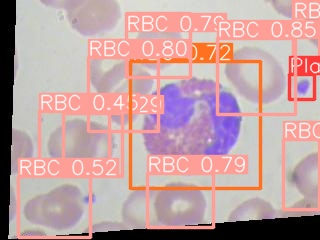

In [94]:
Image(filename=f'{HOME}/dataset2-predictions/TEST/EOSINOPHIL/_0_8473.jpeg', width=600)

Additionally, it saved cropped images of all the white blood cells identified, as shown below:

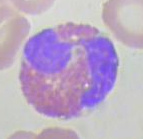

In [95]:
Image(filename=f'{HOME}/dataset2-predictions/TEST/EOSINOPHIL/crops/WBC/_0_8473.jpg', width=600)

These cropped images will allow us to move on to the final stage of our project, which is to classify each white blood cell as one of 4 subtypes (EOSINOPHIL, LYMPHOCYTE, MONOCYTE, and NEUTROPHIL)